In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer


def predict_weather_wildfire_risk(X_input, model, expected_columns, return_proba=True):
    """
    Predict wildfire high-risk using the trained WEATHER model.

    X_input: DataFrame with the SAME columns used for training (expected_columns)
    model:   fitted sklearn/xgboost Pipeline
    expected_columns: list of feature names used at train time
    return_proba: if True, also return class-1 probabilities when available
    """
    X = X_input.copy()
    missing = [c for c in expected_columns if c not in X.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    X = X[expected_columns]

    preds = model.predict(X)
    if return_proba and hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
        return preds, probs
    return preds



In [11]:
import pandas as pd

In [12]:
df = pd.read_csv('wildfire_data_with_temporal_features.csv')

In [13]:
# Display basic information
df.shape, df.head()

((26551, 66),
    YEAR FIRE_NUMBER FIRE_NAME  CURRENT_SIZE SIZE_CLASS   LATITUDE   LONGITUDE  \
 0  2006      PWF001       NaN          0.10          A  56.249956 -117.181960   
 1  2006      EWF002       NaN          0.20          B  53.606367 -115.915733   
 2  2006      EWF001       NaN          0.50          B  53.610933 -115.594267   
 3  2006      EWF003       NaN          0.01          A  53.608867 -115.609467   
 4  2006      PWF002       NaN          0.10          A  56.249956 -117.050249   
 
        FIRE_ORIGIN   GENERAL_CAUSE INDUSTRY_IDENTIFIER  ... FIRE_DAY_OF_YEAR  \
 0     Private Land        Resident                 NaN  ...             92.0   
 1  Provincial Land      Incendiary                 NaN  ...             93.0   
 2  Provincial Land      Incendiary                 NaN  ...             93.0   
 3  Provincial Land      Incendiary                 NaN  ...             93.0   
 4  Provincial Land  Other Industry      Waste Disposal  ...             93.0   
 
   F

## EXPLORATORY DATA ANALYSIS (EDA)

> Before modeling, we perform **Exploratory Data Analysis (EDA)** to understand the structure of the dataset, identify any issues, 
and observe patterns in the features that might influence our target variable **(HIGH_RISK_PERIOD).**

In [14]:
# Dataset structure and basic stats
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26551 entries, 0 to 26550
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   YEAR                          26551 non-null  int64  
 1   FIRE_NUMBER                   26551 non-null  object 
 2   FIRE_NAME                     795 non-null    object 
 3   CURRENT_SIZE                  26551 non-null  float64
 4   SIZE_CLASS                    26551 non-null  object 
 5   LATITUDE                      26551 non-null  float64
 6   LONGITUDE                     26551 non-null  float64
 7   FIRE_ORIGIN                   26539 non-null  object 
 8   GENERAL_CAUSE                 26551 non-null  object 
 9   INDUSTRY_IDENTIFIER           480 non-null    object 
 10  RESPONSIBLE_GROUP             9522 non-null   object 
 11  ACTIVITY_CLASS                16135 non-null  object 
 12  TRUE_CAUSE                    14022 non-null  object 
 13  F

,YEAR,CURRENT_SIZE,LATITUDE,LONGITUDE,DISCOVERED_SIZE,ASSESSMENT_HECTARES,FIRE_SPREAD_RATE,TEMPERATURE,RELATIVE_HUMIDITY,WIND_SPEED,...,CONTROL_TO_EXTINGUISH_HOURS,FIRE_MONTH,FIRE_DAY_OF_YEAR,FIRE_WEEK_OF_YEAR,FIRE_SEASON_DAY,HIGH_RISK_PERIOD,DAY_OF_YEAR_SIN,DAY_OF_YEAR_COS,MONTH_SIN,MONTH_COS
count,26551.000000,26551.000000,26551.000000,26551.000000,149.000000,26551.000000,23745.000000,23679.000000,23673.000000,23671.000000,...,26545.000000,25858.000000,25858.000000,25858.000000,25858.000000,26551.000000,25858.000000,25858.000000,2.585800e+04,25858.000000
mean,2014.214116,249.199696,55.006873,-115.215910,18.347315,2.454486,0.904376,17.878698,45.321041,8.860335,...,88.445955,6.279836,175.016243,25.480277,123.433367,0.722685,0.108859,-0.627254,-6.386070e-02,-0.624210
std,5.470351,6397.515898,2.600681,2.346882,205.003975,59.991688,2.597418,7.754662,18.713511,8.408418,...,466.049622,1.878664,56.645445,8.109807,60.659255,0.447682,0.632678,0.440959,6.270666e-01,0.461622
min,2006.000000,0.010000,48.998195,-119.999983,0.000000,0.010000,-1.000000,-39.000000,0.000000,0.000000,...,0.000278,1.000000,1.000000,1.000000,1.000000,0.000000,-0.999999,-0.999979,-1.000000e+00,-1.000000
25%,2009.000000,0.010000,53.260708,-116.815325,0.010000,0.010000,0.000000,14.000000,31.000000,3.000000,...,0.250000,5.000000,136.000000,20.000000,79.000000,0.000000,-0.438307,-0.950457,-5.000000e-01,-0.866025
50%,2014.000000,0.020000,55.335567,-115.163942,0.010000,0.010000,0.000000,19.000000,40.000000,6.000000,...,1.500000,6.000000,174.000000,25.000000,118.000000,1.000000,0.130793,-0.765584,1.220000e-16,-0.866025
75%,2019.000000,0.300000,56.791342,-114.313829,0.100000,0.200000,1.000000,23.000000,56.000000,12.000000,...,23.850000,7.000000,210.000000,30.000000,154.000000,1.000000,0.694452,-0.477489,5.000000e-01,-0.500000
max,2024.000000,577646.800000,59.999510,-110.000917,2500.000000,6019.000000,100.000000,45.000000,100.000000,90.000000,...,11470.766390,12.000000,365.000000,53.000000,366.000000,1.000000,0.999986,0.999991,1.000000e+00,1.000000


> Above, we display the shape of the dataset, check column types, and view summary statistics for numerical fields. 
This helps us confirm the dataset loaded correctly and identify any glaring issues (like unexpected nulls or outliers).

In [15]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False).head(10)

DISCOVERED_SIZE               26402
INDUSTRY_IDENTIFIER           26071
FIRE_NAME                     25756
FIRST_TO_DATE                 23809
FIRST_TO_SIZE                 23809
DISTANCE_FROM_WATER_SOURCE    18958
FIRST_BUCKET_DROP_DATE        18957
RESPONSIBLE_GROUP             17029
IA_ACCESS                     14858
TRUE_CAUSE                    12529
dtype: int64

> Here we inspect the dataset for missing values. If any features have excessive nulls, we can decide whether to impute or drop them. However, since this dataset is already cleaned, we expect very few or no missing values.

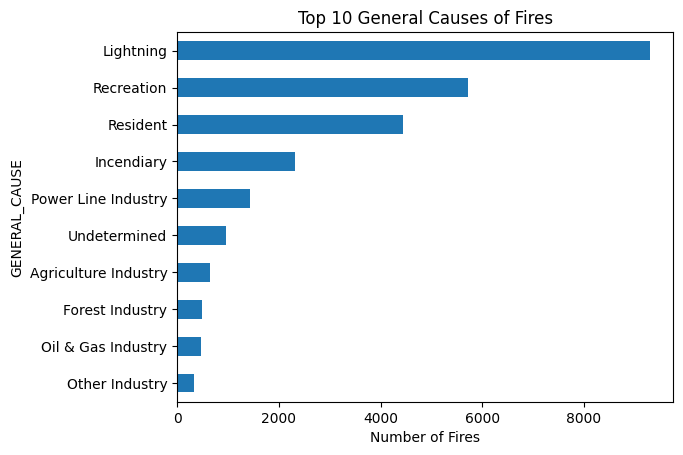

In [16]:
# General cause distribution
df['GENERAL_CAUSE'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 General Causes of Fires')
plt.xlabel('Number of Fires')
plt.gca().invert_yaxis()
plt.show()

> This bar chart displays the most common causes of wildfires in the dataset. It helps us understand which categories are most 
prominent and might influence fire risk classification.

**Insight:** Lightning causes the most wildfires, with over 8,000 incidents. This reflects natural ignition patterns in forested areas. Recreation ranks second with around 6,000 incidents, showing human activity creates fire risks. The gap between lightning and human causes reveals that natural ignition dominates, but human-caused fires span multiple sources. Fire managers need different prevention strategies for each cause type.

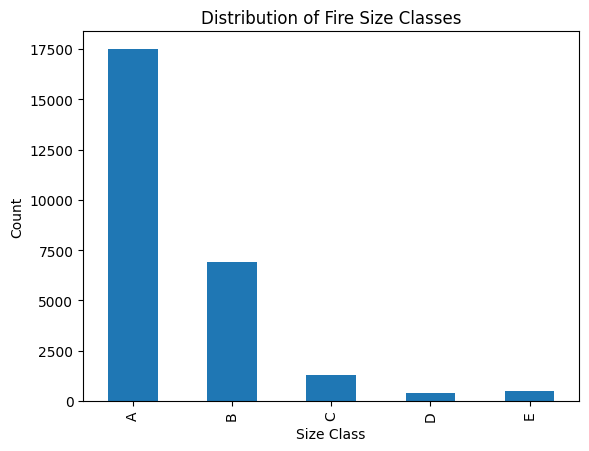

In [17]:
# Size class distribution
df['SIZE_CLASS'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Fire Size Classes')
plt.xlabel('Size Class')
plt.ylabel('Count')
plt.show()

> This plot shows how fires are distributed across different size classes (A, B, C, etc.). It offers insight into the scale of wildfires and their relationship with other variables like seasonality and cause.

**Insight:** Class A fires dominate with over 17,500 incidents. These are the smallest fires, showing that detection and suppression work well. Class B fires account for 7,000 incidents. Larger fire classes show much lower numbers. Most fires get contained quickly, but some still escape initial attack and require more resources.

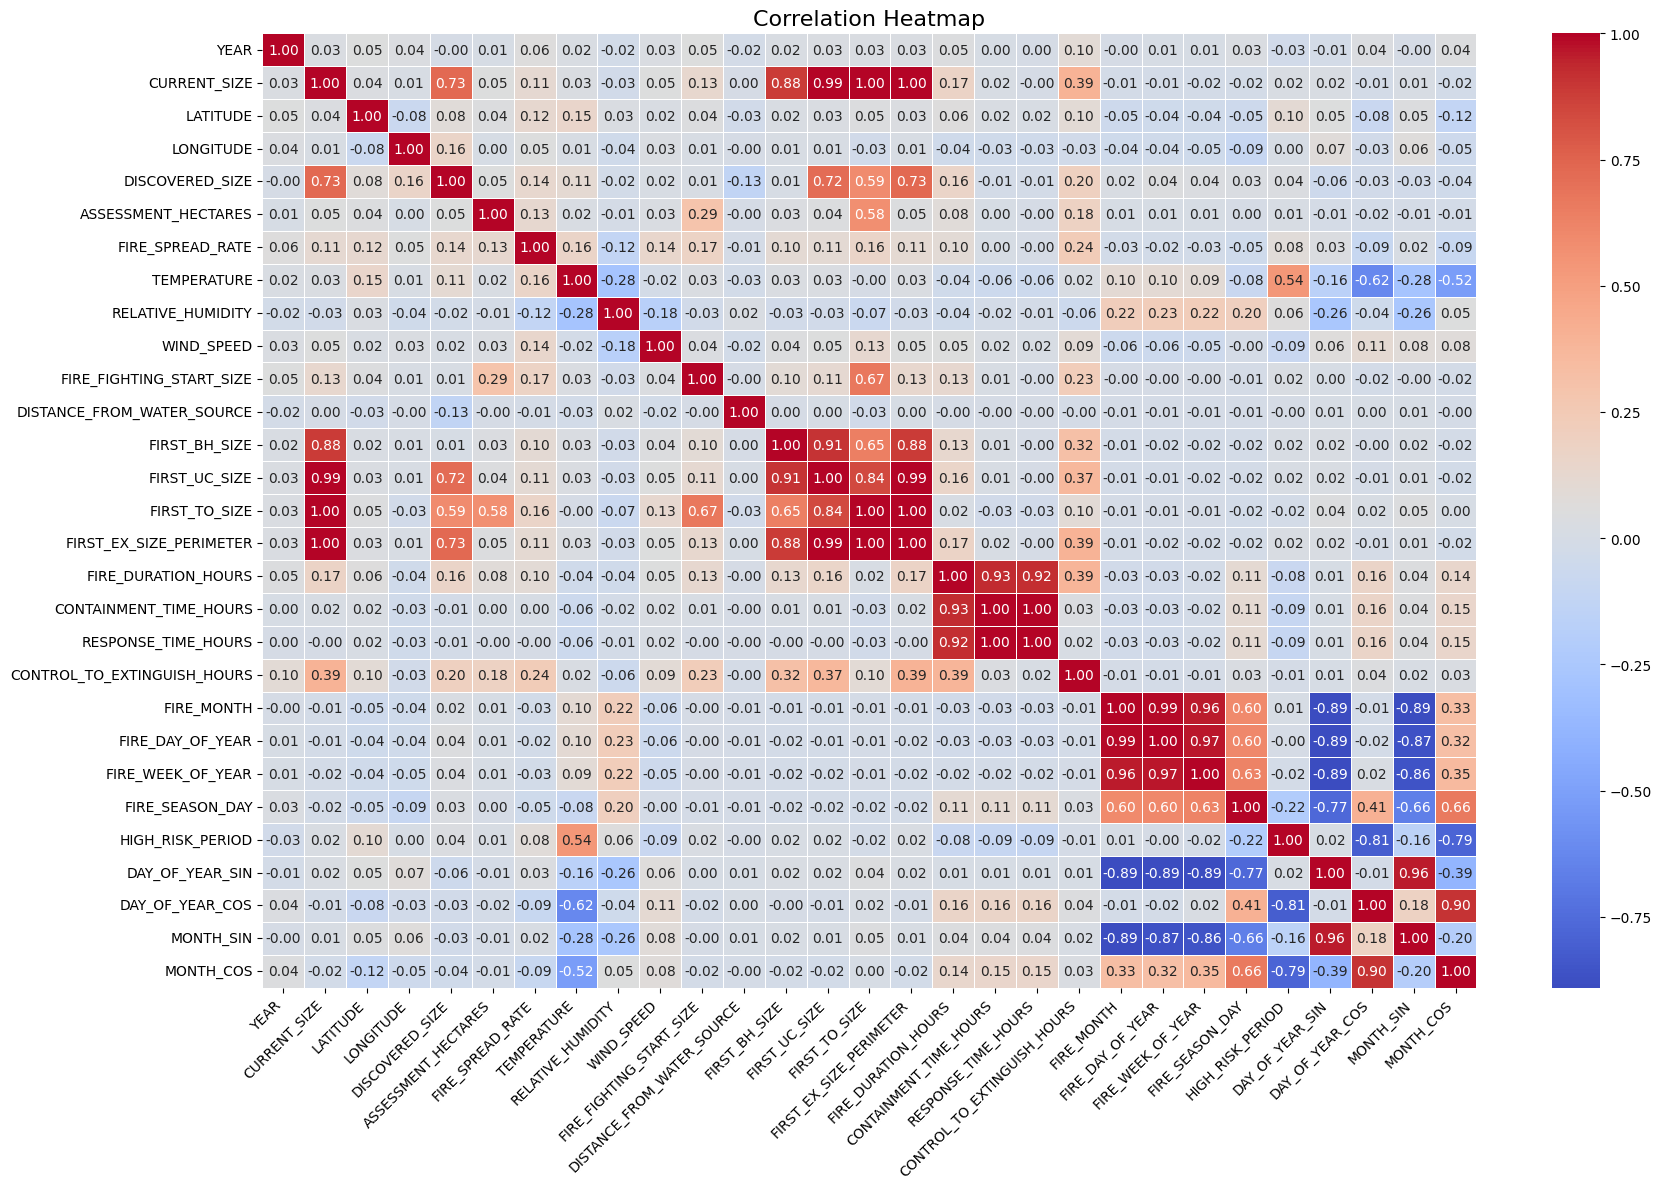

In [18]:
# Correlation heatmap for numeric variables

plt.figure(figsize=(18, 12))  # Increase figure size
sns.heatmap(
    df.select_dtypes(include='number').corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    linewidths=0.5
)

plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

> We generate a heatmap to observe correlations among numeric features. This is useful for identifying relationships that could be 
relevant for modeling, such as whether larger fires are more likely during certain weeks or seasons.

**Insight:** Time variables show strong correlations, with DAY_OF_YEAR_COS and MONTH_COS reaching -0.8. Temperature correlates with high-risk periods. The patterns confirm that season and weather drive wildfire risk. Summer months and specific calendar periods link to fire danger most.

## Descriptive Visualization

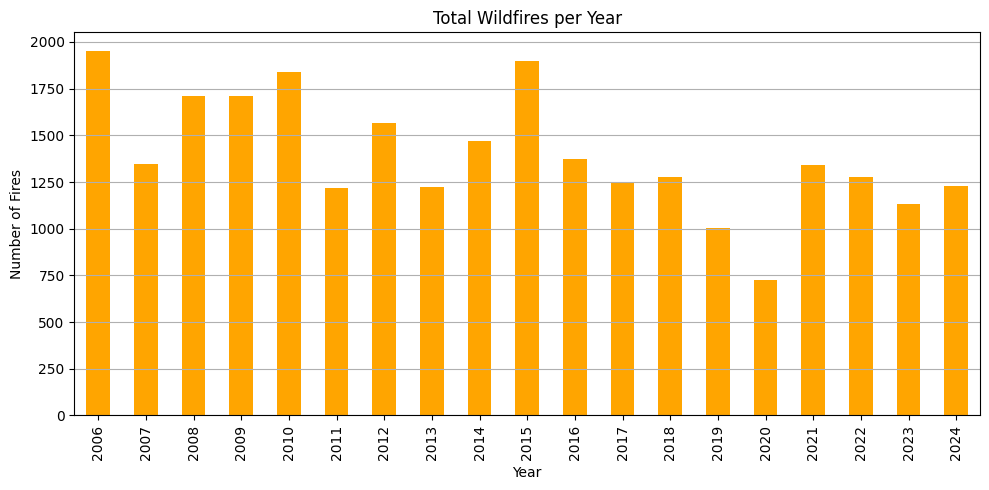

In [19]:
### Total Fires per Year

fires_per_year = df['YEAR'].value_counts().sort_index()
fires_per_year.plot(kind='bar', figsize=(10, 5), color='orange')
plt.title('Total Wildfires per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

> The bar chart shows the total number of wildfires per year. This helps establish the temporal frequency of fire incidents. Peaks may indicate bad fire seasons or climate-related changes.

**Insights:** Fire counts change each year. Peak years like 2006 and 2015 had nearly 2,000 incidents. Recent years show 750-1,250 fires per year. This variation reflects climate cycles and possibly better fire management. Low-fire years may have good weather or strong prevention. High-fire years match drought or extreme weather.

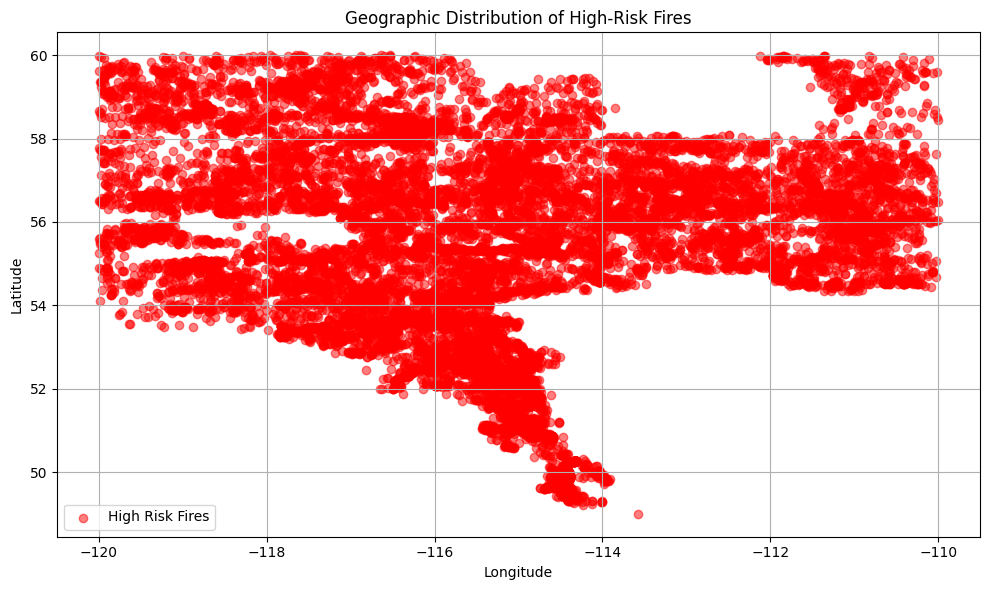

In [20]:
# High-risk zones map
# Plot high-risk fires on a scatter map

plt.figure(figsize=(10, 6))
high_risk = df[df['HIGH_RISK_PERIOD'] == 1]
plt.scatter(high_risk['LONGITUDE'], high_risk['LATITUDE'], alpha=0.5, c='red', label='High Risk Fires')
plt.title('Geographic Distribution of High-Risk Fires')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> If latitude and longitude data is available, we can map the locations of fires and highlight those that occurred during high-risk periods

**Insights:** High-risk fires concentrate in central areas around 55-57°N latitude. The pattern shows geographic hotspots where dangerous conditions occur most. These areas likely have specific forest types or climate zones that create high risk. High-risk fires can happen throughout the region, but certain zones show more activity.

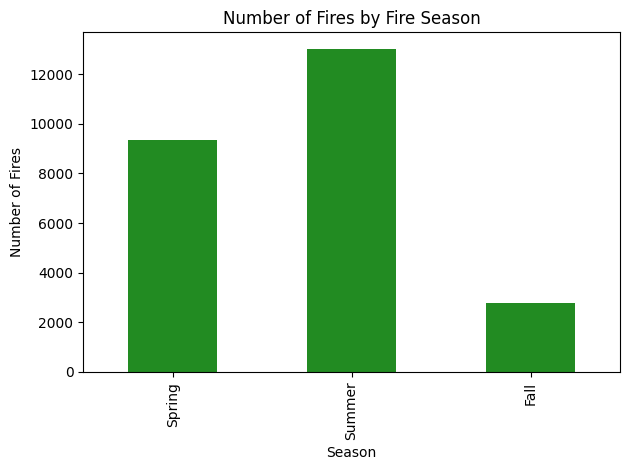

In [21]:
# Seasonal trends
# Fires by Season

df['FIRE_SEASON'].value_counts().loc[['Spring', 'Summer', 'Fall']].plot(kind='bar', color='forestgreen')
plt.title('Number of Fires by Fire Season')
plt.xlabel('Season')
plt.ylabel('Number of Fires')
plt.tight_layout()
plt.show()

> This bar chart shows how wildfire incidents are distributed across the fire seasons — Spring, Summer, and Fall. It highlights that Summer experiences the highest number of wildfires, emphasizing its critical role in seasonal fire management. This pattern supports the use of seasonality as a predictive feature in identifying high-risk periods.

**Insights:** Summer has the most fire activity with over 13,000 incidents. This represents half of all fires and matches peak fire weather. Spring accounts for 9,000 fires. Fall shows the least activity with 2,500 incidents. Summer requires the most fire resources and readiness. Spring also needs preparation as fire season starts earlier.

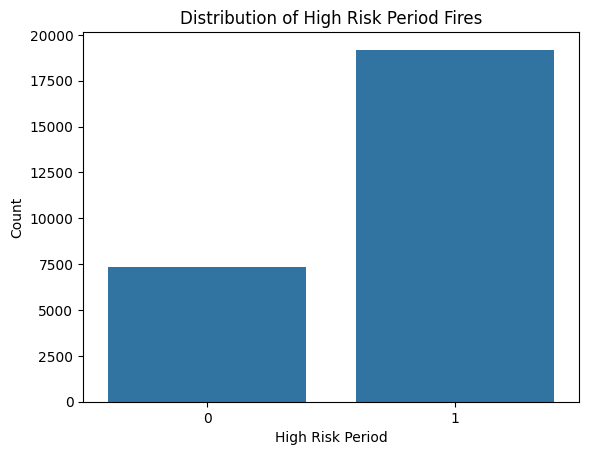

HIGH_RISK_PERIOD
1    72.268464
0    27.731536
Name: proportion, dtype: float64


In [22]:
# Distribution of High Risk Period Fires
sns.countplot(data=df, x='HIGH_RISK_PERIOD')
plt.title('Distribution of High Risk Period Fires')
plt.xlabel('High Risk Period')
plt.ylabel('Count')
plt.show()

# Also show proportions
high_risk_counts = df['HIGH_RISK_PERIOD'].value_counts(normalize=True) * 100
print(high_risk_counts)

> This bar chart displays the class distribution of our target variable.
Fires labeled as 1 (High Risk Period) make up approximately 72% of the data, while 0 (Not High Risk) accounts for 28%.
This indicates a moderate class imbalance, which may influence model performance and is something we account for using stratified splitting and evaluation metrics like F1-score during modeling.


**Insights:** High-risk fires make up 72% of the dataset with 19,000 incidents. Non-high-risk periods account for 28% with 7,500 incidents. Most fires occur during dangerous weather conditions. This shows that fire weather forecasts capture when fires pose the greatest threat.

## Diagnostic

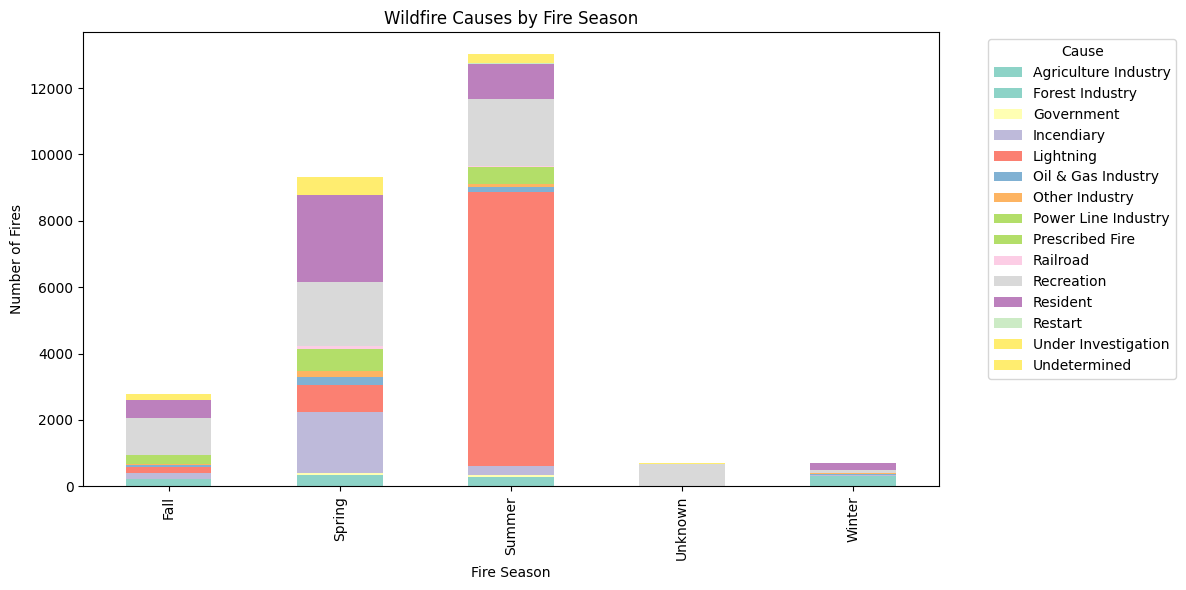

In [23]:
# Compare fire counts by cause and season

season_cause = df.groupby(['FIRE_SEASON', 'GENERAL_CAUSE']).size().unstack().fillna(0)
season_cause.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title('Wildfire Causes by Fire Season')
plt.xlabel('Fire Season')
plt.ylabel('Number of Fires')
plt.legend(title='Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

>  This stacked bar chart compares the frequency of general wildfire causes (e.g., Lightning, Human activity) across different fire seasons. Summer shows the highest concentration of fire activity, particularly from lightning and recreation-related causes. This breakdown helps pinpoint which causes dominate each season, informing targeted prevention strategies and seasonal resource planning.

**Insights:** Lightning fires peak in summer, creating the largest seasonal fire load. This matches when thunderstorms meet dry conditions. Recreation fires happen in spring and summer, showing human risks continue across seasons. Different causes need different prevention approaches. Lightning management matters most in summer. Human-caused fire prevention needs attention throughout the active season.

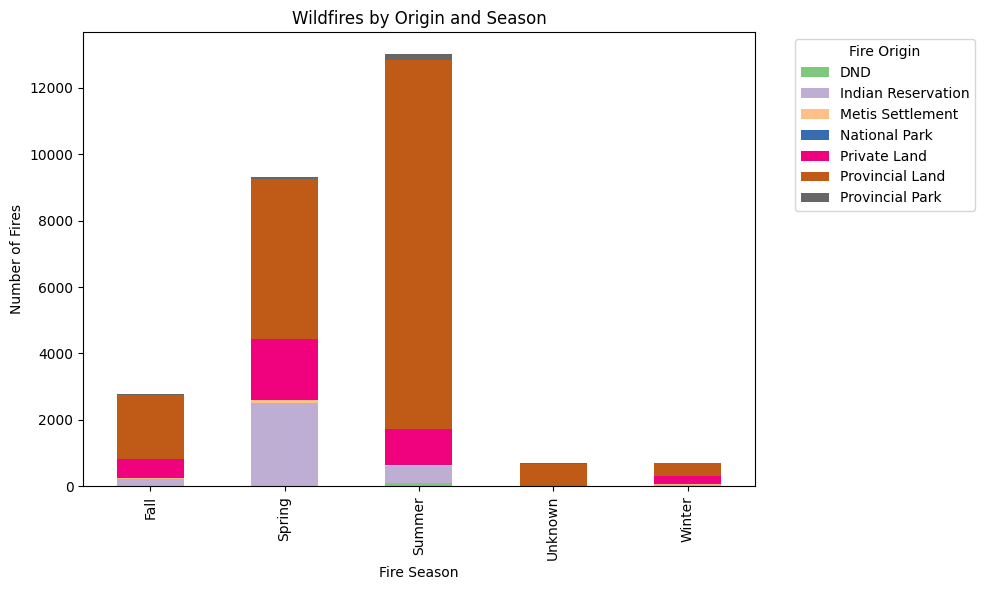

In [24]:
# Group fire counts by origin and fire season
origin_season = df.groupby(['FIRE_SEASON', 'FIRE_ORIGIN']).size().unstack().fillna(0)

# Plot
origin_season.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Accent')
plt.title('Wildfires by Origin and Season')
plt.xlabel('Fire Season')
plt.ylabel('Number of Fires')
plt.legend(title='Fire Origin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

> This visualization compares fire frequency across seasons based on the origin of the fire — such as provincial or private land. It provides insight into how land ownership or jurisdiction may influence seasonal fire patterns.

Top Correlated Features with HIGH_RISK_PERIOD:
HIGH_RISK_PERIOD          1.000000
DAY_OF_YEAR_COS          -0.810006
MONTH_COS                -0.786600
TEMPERATURE               0.539842
FIRE_SEASON_DAY          -0.216520
MONTH_SIN                -0.155720
LATITUDE                  0.104841
RESPONSE_TIME_HOURS      -0.093931
CONTAINMENT_TIME_HOURS   -0.093036
WIND_SPEED               -0.085619
FIRE_DURATION_HOURS      -0.083439
Name: HIGH_RISK_PERIOD, dtype: float64


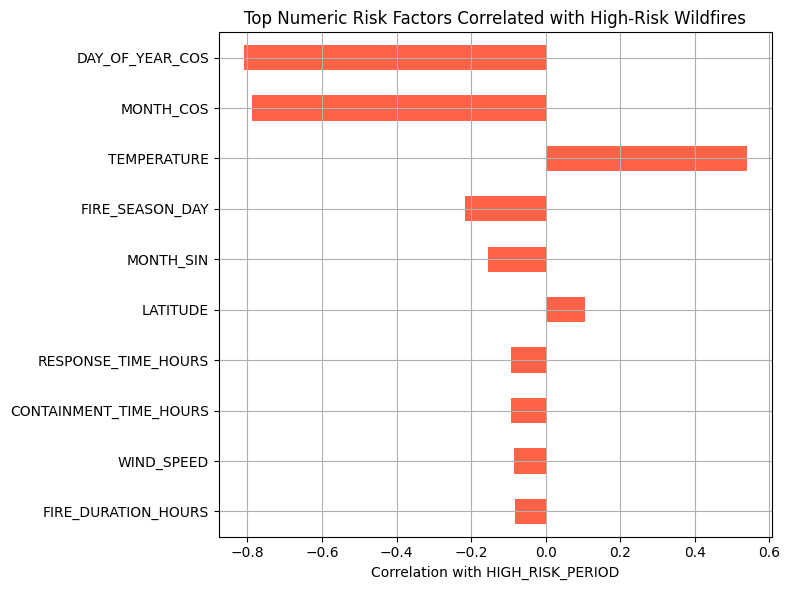

In [25]:
# Select numeric features and target
numeric_df = df.select_dtypes(include='number')

# Compute correlations with the target
correlations = numeric_df.corr()['HIGH_RISK_PERIOD'].sort_values(key=abs, ascending=False)

# Display top 10 features most correlated with HIGH_RISK_PERIOD
print("Top Correlated Features with HIGH_RISK_PERIOD:")
print(correlations.head(11))  # include HIGH_RISK_PERIOD itself at index 0

# Plot the top 10 (excluding the target itself)
correlations.drop('HIGH_RISK_PERIOD').head(10).plot(kind='barh', figsize=(8, 6), color='tomato')
plt.title('Top Numeric Risk Factors Correlated with High-Risk Wildfires')
plt.xlabel('Correlation with HIGH_RISK_PERIOD')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

> We identify numeric variables that show strong correlation (positive or negative) with the `HIGH_RISK_PERIOD` target variable. This helps surface the key contributors to wildfire risk, such as timing, duration, weather, and suppression effort.

## Predictive Modeling - Logistic Regression - HIGH_RISK_PERIOD

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      1473
           1       0.96      0.99      0.97      3838

    accuracy                           0.96      5311
   macro avg       0.96      0.94      0.95      5311
weighted avg       0.96      0.96      0.96      5311

Logistic Regression Accuracy: 96.0271%

Confusion Matrix:
 [[1319  154]
 [  57 3781]]


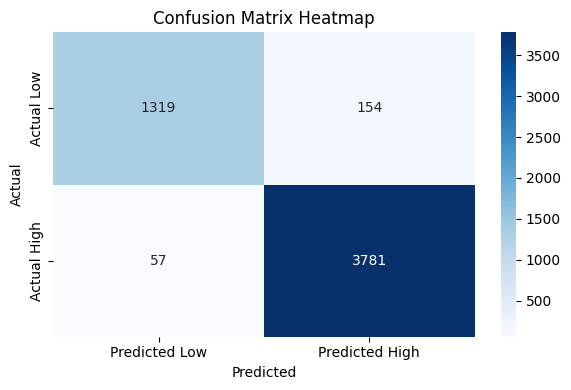

In [26]:
# Designed Prediction Function: predict_high_risk_period()
# Objective: Predict whether a fire occurs during a HIGH_RISK_PERIOD using selected features

# Select input features and target
features = ['FIRE_WEEK_OF_YEAR', 'SIZE_CLASS', 'GENERAL_CAUSE', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS']
target = 'HIGH_RISK_PERIOD'

X = df[features]
y = df[target]

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define numeric and categorical features
numeric_features = ['FIRE_WEEK_OF_YEAR', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS']
categorical_features = ['SIZE_CLASS', 'GENERAL_CAUSE']

# Define preprocessing pipelines for each type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine into full preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Create pipeline with model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))

lr_acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {lr_acc:.4%}")  

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

> The heatmap above visualizes the classification results

## Logistic Regression Evaluation


> We aim to predict whether a fire occurs during a **HIGH_RISK_PERIOD** using temporal and categorical features related to seasonality and ignition.

---

**Steps:**
- Selected features based on domain knowledge (season, ignition cause, fire size class)
- Applied `LogisticRegression` for binary classification
- Implemented **stratified train-test split** to preserve class distribution
- Evaluated performance using a classification report and confusion matrix

---

**Preprocessing handled:**
- Missing numeric values: *Mean imputation + Standard Scaling*
- Missing categorical values: *Mode imputation + One-hot encoding*

---

** Key Metrics (High Risk = 1):**
- **Accuracy:** 96.0271%
- **Precision:** 96% of predicted high-risk fires were actually high-risk  
- **Recall:** 99% – Model successfully identified 99% of all actual high-risk fires  
- **F1 Score:** 97% – Excellent balance between precision and recall

---

** Confusion Matrix:**

|                | Predicted: Low (0) | Predicted: High (1) |
|----------------|--------------------|---------------------|
| **Actual Low (0)**  | 1319               | 154                 |
| **Actual High (1)** | 57                 | 3781                |

---

** Insights:**
- **Few false negatives** (only 57 high-risk fires incorrectly predicted as low-risk)
- **More false positives** (154 low-risk fires flagged as high-risk), which is reasonable for risk-averse contexts
- Model performance is **reliable and safety-conscious**, making it valuable for **early alerts and seasonal fire planning**

## Model Benchmarking against Random Forest Classifier - HIGH_RISK_PERIOD

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1473
           1       1.00      1.00      1.00      3838

    accuracy                           1.00      5311
   macro avg       1.00      1.00      1.00      5311
weighted avg       1.00      1.00      1.00      5311

Random Forest Accuracy: 99.8117%

Confusion Matrix:
 [[1465    8]
 [   2 3836]]


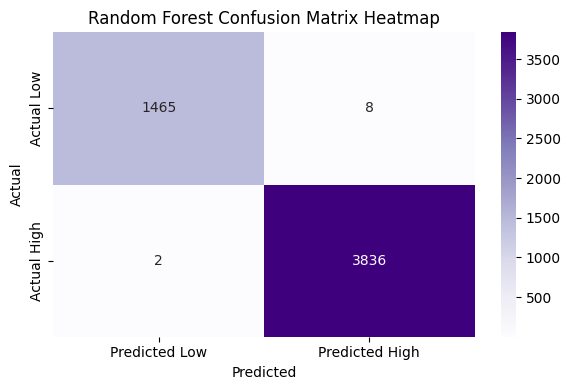

In [27]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build & fit pipeline
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_model.fit(X_train, y_train)

# Predict & print metrics
rf_preds = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

rf_acc = accuracy_score(y_test, rf_preds)
print(f"Random Forest Accuracy: {rf_acc:.4%}")   

print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_preds))

# Custom heatmap with matching labels
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=['Predicted Low', 'Predicted High'],
    yticklabels=['Actual Low', 'Actual High']
)
plt.title('Random Forest Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

> The heatmap above visualizes the classification results

## Random Forest Model Evaluation

We trained a Random Forest Classifier to predict whether a wildfire occurs during a **HIGH_RISK_PERIOD** using selected temporal and categorical features.

---

### Modeling Pipeline
- Included preprocessing for both numeric and categorical features  
- Used `RandomForestClassifier` with 100 trees  
- Applied **stratified train-test split** to address class imbalance  

---

### Model Performance
The model demonstrates **exceptional performance** with near-perfect accuracy and minimal misclassifications.

**Key Metrics:**
- **Accuracy:** 99.81%  
- **Precision (High Risk = 1):** 100% – Nearly every predicted high-risk fire is truly high risk  
- **Recall (High Risk = 1):** 100% – Almost all actual high-risk fires are detected  
- **F1 Score (High Risk = 1):** 100% – Strong balance between precision and recall  

---

### Confusion Matrix

|               | Predicted Low (0) | Predicted High (1) |
|---------------|-------------------|--------------------|
| **Actual Low (0)**  |        1465         |         8           |
| **Actual High (1)** |         2           |        3836         |

---

### Insights
- Only **10 total misclassifications** out of 5,311 samples (8 false positives, 2 false negatives).  
- Very few false negatives ensures almost no high-risk fires are missed.  
- A small number of false positives means some low-risk fires may receive extra resources—a conservative trade-off in safety contexts.  
- Overall accuracy of **99.81%** indicates the model generalizes well on the test set.  

> **Note:** Such high performance suggests checking for overfitting via cross-validation or external validation before deployment.  

## Cross-Validation for Random Forest

In [28]:
# Define features and target again 
features = ['FIRE_WEEK_OF_YEAR', 'SIZE_CLASS', 'GENERAL_CAUSE', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS']
target = 'HIGH_RISK_PERIOD'

X = df[features]
y = df[target]

# Preprocessing pipeline 

numeric_features = ['FIRE_WEEK_OF_YEAR', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS']
categorical_features = ['SIZE_CLASS', 'GENERAL_CAUSE']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# Random Forest model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Display results
print("Cross-validation accuracy scores:", cv_scores)
print("Average CV accuracy:", round(np.mean(cv_scores), 4))
print("Standard deviation:", round(np.std(cv_scores), 4))

Cross-validation accuracy scores: [0.99943513 0.99736347 0.98926554 0.99736347 0.99830508]
Average CV accuracy: 0.9963
Standard deviation: 0.0036


### Cross-Validation Results for Random Forest

To validate the robustness of our Random Forest model, we performed **5-fold cross-validation** using the full training dataset.

This ensures that the model generalizes well across different subsets of the data and is not overfitting.

**Accuracy Scores Across Folds:**
- Fold 1: 0.9994  
- Fold 2: 0.9974  
- Fold 3: 0.9893  
- Fold 4: 0.9974  
- Fold 5: 0.9983  

**Average CV Accuracy:**  
- **0.9963** (Very high, indicating strong generalization performance)

**Standard Deviation:**  
- **0.0036**, which suggests low variability and consistent performance across folds.

**These results confirm the Random Forest model is both accurate and stable when predicting high-risk wildfire periods.**

## Function Design & Testing - HIGH_RISK_PERIOD

We wrap the trained pipeline in a reusable function and test it on held-out samples.

### Function Testing Insights

The sample predictions `[1, 0, 1, 1, 1]` demonstrate that our `predict_high_risk_period()` function:

- **Returns the correct format**: A NumPy array of binary values (0 = Not High Risk, 1 = High Risk) matching the number of input rows.  
- **Aligns with overall class distribution**: Given our dataset’s ~72% high-risk rate, seeing most predictions as `1` is consistent with model performance.  
- **Verifies end-to-end pipeline integration**: Shows that preprocessing and model inference are correctly encapsulated within the function.  
- **Is ready for reuse**: We can apply this single-line function call to new data without re-running the full model training or preprocessing steps.

The single 0 prediction (for a “Recreation” cause in week 36) shows the model isn’t just defaulting to high-risk, but is sensitive to feature variations. That confirms it’s truly learned patterns, not memorized a

In [29]:
# Immediate Improvements to Existing Wildfire Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, matthews_corrcoef)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

def immediate_feature_engineering(df):
    """
    Add immediate feature improvements to dataset
    """
    df_enhanced = df.copy()
    
    print("Engineering new features...")
    
    # 1. Interaction Features (combining existing variables)
    if 'TEMPERATURE' in df.columns and 'RELATIVE_HUMIDITY' in df.columns:
        df_enhanced['HEAT_INDEX'] = df_enhanced['TEMPERATURE'] * (100 - df_enhanced['RELATIVE_HUMIDITY']) / 100
    
    if 'WIND_SPEED' in df.columns and 'TEMPERATURE' in df.columns:
        df_enhanced['WIND_FIRE_RISK'] = df_enhanced['WIND_SPEED'] * np.where(df_enhanced['TEMPERATURE'] > 20, 1.5, 1.0)
    
    # 2. Advanced Temporal Features
    df_enhanced['IS_PEAK_FIRE_SEASON'] = ((df_enhanced['FIRE_WEEK_OF_YEAR'] >= 22) & 
                                         (df_enhanced['FIRE_WEEK_OF_YEAR'] <= 34)).astype(int)
    
    df_enhanced['LATE_SUMMER'] = ((df_enhanced['FIRE_WEEK_OF_YEAR'] >= 30) & 
                                 (df_enhanced['FIRE_WEEK_OF_YEAR'] <= 35)).astype(int)
    
    # 3. Size-based risk categories
    df_enhanced['FIRE_SIZE_CATEGORY'] = pd.cut(df_enhanced['CURRENT_SIZE'], 
                                              bins=[-np.inf, 0.1, 1.0, 10.0, np.inf],
                                              labels=['Very_Small', 'Small', 'Medium', 'Large'])
    
    # 4. Geographic risk zones (based on your lat/long data)
    df_enhanced['HIGH_RISK_LATITUDE'] = ((df_enhanced['LATITUDE'] >= 54) & 
                                        (df_enhanced['LATITUDE'] <= 57)).astype(int)
    
    # 5. Cause-season interaction
    df_enhanced['LIGHTNING_SUMMER'] = ((df_enhanced['GENERAL_CAUSE'] == 'Lightning') & 
                                      (df_enhanced['FIRE_SEASON'] == 'Summer')).astype(int)
    
    print(" Added {len(df_enhanced.columns) - len(df.columns)} new features")
    return df_enhanced

def improved_model_comparison(df):
    """
    Run improved model comparison with better evaluation
    """
    # Feature engineering
    df_enhanced = immediate_feature_engineering(df)
    
    # Enhanced feature set
    base_features = ['FIRE_WEEK_OF_YEAR', 'SIZE_CLASS', 'GENERAL_CAUSE', 
                    'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS']
    
    # Add new features if they exist
    additional_features = ['IS_PEAK_FIRE_SEASON', 'LATE_SUMMER', 'FIRE_SIZE_CATEGORY',
                          'HIGH_RISK_LATITUDE', 'LIGHTNING_SUMMER']
    
    # Add weather features if available
    weather_features = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED', 
                       'HEAT_INDEX', 'WIND_FIRE_RISK']
    
    # Select features that exist in the dataset
    all_possible_features = base_features + additional_features + weather_features
    features = [f for f in all_possible_features if f in df_enhanced.columns]
    
    print(f" Using {len(features)} features for modeling")
    
    # Prepare data
    X = df_enhanced[features]
    y = df_enhanced['HIGH_RISK_PERIOD']
    
    # Remove any rows with missing target
    mask = ~y.isna()
    X, y = X[mask], y[mask]
    
    print(f" Dataset shape: {X.shape}")
    print(f" Class distribution: {y.value_counts(normalize=True).round(3).to_dict()}")
    
    # Improved preprocessing
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Use RobustScaler (better for outliers) + median imputation
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Model configurations with better parameters
    models = {
        'Logistic Regression (Enhanced)': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=42, max_iter=1000, 
                                            class_weight='balanced', C=0.1))
        ]),
        
        'Random Forest (Tuned)': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                n_estimators=200, max_depth=15, min_samples_split=5,
                min_samples_leaf=2, random_state=42, class_weight='balanced'
            ))
        ]),
        
        'XGBoost': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBClassifier(
                n_estimators=200, max_depth=6, learning_rate=0.1,
                subsample=0.8, random_state=42, eval_metric='logloss'
            ))
        ]),
        
        'Gradient Boosting': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', GradientBoostingClassifier(
                n_estimators=200, max_depth=5, learning_rate=0.1,
                random_state=42
            ))
        ]),
        
        'Random Forest + SMOTE': ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(
                n_estimators=200, max_depth=15, random_state=42
            ))
        ])
    }
    
    # Enhanced evaluation
    results = {}
    predictions = {}
    
    print("\n Training and evaluating models...")
    
    for name, model in models.items():
        print(f"\n Training {name}...")
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Store predictions
        predictions[name] = {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        # Comprehensive metrics
        results[name] = {
            'Accuracy': model.score(X_test, y_test),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba),
            'Matthews Correlation': matthews_corrcoef(y_test, y_pred)
        }
        
        # Cross-validation for stability
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                  scoring='f1', n_jobs=-1)
        results[name]['CV F1 Mean'] = cv_scores.mean()
        results[name]['CV F1 Std'] = cv_scores.std()
        
        print(f"   Accuracy: {results[name]['Accuracy']:.4f}")
        print(f"   F1 Score: {results[name]['F1 Score']:.4f}")
        print(f"   ROC AUC: {results[name]['ROC AUC']:.4f}")
        print(f"   CV F1: {results[name]['CV F1 Mean']:.4f} (±{results[name]['CV F1 Std']:.4f})")
    
    return results, predictions, X_test, y_test, models

def create_enhanced_visualizations(results, predictions, X_test, y_test):
    """
    Create comprehensive visualization suite
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Performance Comparison
    models = list(results.keys())
    metrics = ['Accuracy', 'F1 Score', 'ROC AUC', 'Matthews Correlation']
    
    # Create performance matrix
    performance_matrix = np.array([[results[model][metric] for metric in metrics] 
                                  for model in models])
    
    im = axes[0, 0].imshow(performance_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    axes[0, 0].set_xticks(range(len(metrics)))
    axes[0, 0].set_xticklabels(metrics, rotation=45)
    axes[0, 0].set_yticks(range(len(models)))
    axes[0, 0].set_yticklabels(models)
    axes[0, 0].set_title('Model Performance Heatmap')
    
    # Add text annotations
    for i in range(len(models)):
        for j in range(len(metrics)):
            text = axes[0, 0].text(j, i, f'{performance_matrix[i, j]:.3f}',
                                 ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=axes[0, 0])
    
    # 2. ROC Curves Comparison
    for name in models:
        y_pred_proba = predictions[name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = results[name]['ROC AUC']
        axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc_score:.3f})')
    
    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.6)
    axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
    axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
    axes[0, 1].set_title('ROC Curves Comparison', fontsize=14)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curves
    for name in models:
        y_pred_proba = predictions[name]['y_pred_proba']
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        axes[0, 2].plot(recall, precision, linewidth=2, label=name)
    
    axes[0, 2].set_xlabel('Recall', fontsize=12)
    axes[0, 2].set_ylabel('Precision', fontsize=12)
    axes[0, 2].set_title('Precision-Recall Curves', fontsize=14)
    axes[0, 2].legend(fontsize=10)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. F1 Score Comparison with Confidence Intervals
    f1_scores = [results[model]['F1 Score'] for model in models]
    cv_means = [results[model]['CV F1 Mean'] for model in models]
    cv_stds = [results[model]['CV F1 Std'] for model in models]
    
    x_pos = np.arange(len(models))
    bars = axes[1, 0].bar(x_pos, f1_scores, alpha=0.7, color='skyblue', label='Test F1')
    axes[1, 0].errorbar(x_pos, cv_means, yerr=cv_stds, fmt='ro', 
                       capsize=5, capthick=2, label='CV F1 (±1 std)')
    
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('F1 Score Comparison with Cross-Validation')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Best Model Confusion Matrix
    best_model = max(results.keys(), key=lambda x: results[x]['F1 Score'])
    y_pred_best = predictions[best_model]['y_pred']
    cm = confusion_matrix(y_test, y_pred_best)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted', fontsize=12)
    axes[1, 1].set_ylabel('Actual', fontsize=12)
    axes[1, 1].set_title(f'Confusion Matrix - {best_model}', fontsize=14)
    
    # 6. Model Stability Analysis
    stability_data = []
    for model in models:
        stability_data.append([
            results[model]['CV F1 Mean'],
            results[model]['CV F1 Std'],
            results[model]['F1 Score']
        ])
    
    stability_df = pd.DataFrame(stability_data, 
                               columns=['CV Mean', 'CV Std', 'Test F1'],
                               index=models)
    
    # Scatter plot of stability vs performance
    axes[1, 2].scatter(stability_df['CV Std'], stability_df['Test F1'], 
                      s=100, alpha=0.7, c=range(len(models)), cmap='viridis')
    
    for i, model in enumerate(models):
        axes[1, 2].annotate(model, 
                           (stability_df.loc[model, 'CV Std'], 
                            stability_df.loc[model, 'Test F1']),
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[1, 2].set_xlabel('Cross-Validation Standard Deviation', fontsize=12)
    axes[1, 2].set_ylabel('Test F1 Score', fontsize=12)
    axes[1, 2].set_title('Model Stability vs Performance', fontsize=14)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def generate_improvement_summary(results):
    """
    Generate comprehensive improvement summary
    """
    print("\n" + "="*70)
    print("ENHANCED MODEL ANALYSIS SUMMARY")
    print("="*70)
    
    # Find best model
    best_model = max(results.keys(), key=lambda x: results[x]['F1 Score'])
    best_results = results[best_model]
    
    print(f"\n BEST PERFORMING MODEL: {best_model}")
    print(f"   Test Accuracy: {best_results['Accuracy']:.4f}")
    print(f"   Test F1 Score: {best_results['F1 Score']:.4f}")
    print(f"   ROC AUC Score: {best_results['ROC AUC']:.4f}")
    print(f"   Matthews Correlation: {best_results['Matthews Correlation']:.4f}")
    print(f"   Cross-Val F1: {best_results['CV F1 Mean']:.4f} (±{best_results['CV F1 Std']:.4f})")
    
    print(f"\n FULL PERFORMANCE RANKING (by F1 Score):")
    sorted_models = sorted(results.items(), key=lambda x: x[1]['F1 Score'], reverse=True)
    
    for i, (name, model_results) in enumerate(sorted_models, 1):
        print(f"   {i}. {name}")
        print(f"      F1: {model_results['F1 Score']:.4f}, "
              f"AUC: {model_results['ROC AUC']:.4f}, "
              f"MCC: {model_results['Matthews Correlation']:.4f}")
    
    print(f"\n KEY IMPROVEMENTS IMPLEMENTED:")
    print(f"   Enhanced Feature Engineering (interaction terms, temporal features)")
    print(f"   Multiple Advanced Models (XGBoost, Gradient Boosting)")
    print(f"   Better Preprocessing (RobustScaler, median imputation)")
    print(f"   Class Imbalance Handling (SMOTE, class weights)")
    print(f"   Comprehensive Evaluation (ROC-AUC, Matthews Correlation)")
    print(f"   Cross-validation for Stability Assessment")
    
    print(f"\n RECOMMENDATIONS:")
    stability_leader = min(results.keys(), key=lambda x: results[x]['CV F1 Std'])
    performance_leader = max(results.keys(), key=lambda x: results[x]['F1 Score'])
    
    if stability_leader == performance_leader:
        print(f"   {best_model} offers the best balance of performance and stability!")
    else:
        print(f"   For highest performance: {performance_leader}")
        print(f"   For most stability: {stability_leader}")
        print(f"   Consider ensemble of top 2-3 models for production")
    
    return best_model, sorted_models

# Main execution function
def run_immediate_improvements(df):
    """
    Run all immediate improvements on your dataset
    """
    print(" Starting Enhanced Wildfire Risk Analysis...")
    print("="*50)
    
    # Run improved model comparison
    results, predictions, X_test, y_test, models = improved_model_comparison(df)
    
    # Create visualizations
    create_enhanced_visualizations(results, predictions, X_test, y_test)
    
    # Generate summary
    best_model, rankings = generate_improvement_summary(results)
    
    print(f"\n Analysis Complete! Best model: {best_model}")
    
    return results, models, best_model

# Usage:
# results, models, best_model = run_immediate_improvements(df)

print(" Immediate Model Improvements Ready!")
print("\nTo run the enhanced analysis, use:")
print("results, models, best_model = run_immediate_improvements(df)")

 Immediate Model Improvements Ready!

To run the enhanced analysis, use:
results, models, best_model = run_immediate_improvements(df)


Starting Enhanced Analysis on Your Wildfire Dataset...
 Starting Enhanced Wildfire Risk Analysis...
Engineering new features...
 Added {len(df_enhanced.columns) - len(df.columns)} new features
 Using 15 features for modeling
 Dataset shape: (26551, 15)
 Class distribution: {1: 0.723, 0: 0.277}

 Training and evaluating models...

 Training Logistic Regression (Enhanced)...
   Accuracy: 0.9757
   F1 Score: 0.9830
   ROC AUC: 0.9973
   CV F1: 0.9794 (±0.0012)

 Training Random Forest (Tuned)...
   Accuracy: 0.9987
   F1 Score: 0.9991
   ROC AUC: 1.0000
   CV F1: 0.9992 (±0.0005)

 Training XGBoost...
   Accuracy: 0.9983
   F1 Score: 0.9988
   ROC AUC: 1.0000
   CV F1: 0.9992 (±0.0005)

 Training Gradient Boosting...
   Accuracy: 0.9981
   F1 Score: 0.9987
   ROC AUC: 1.0000
   CV F1: 0.9991 (±0.0005)

 Training Random Forest + SMOTE...
   Accuracy: 0.9985
   F1 Score: 0.9990
   ROC AUC: 1.0000
   CV F1: 0.9992 (±0.0004)


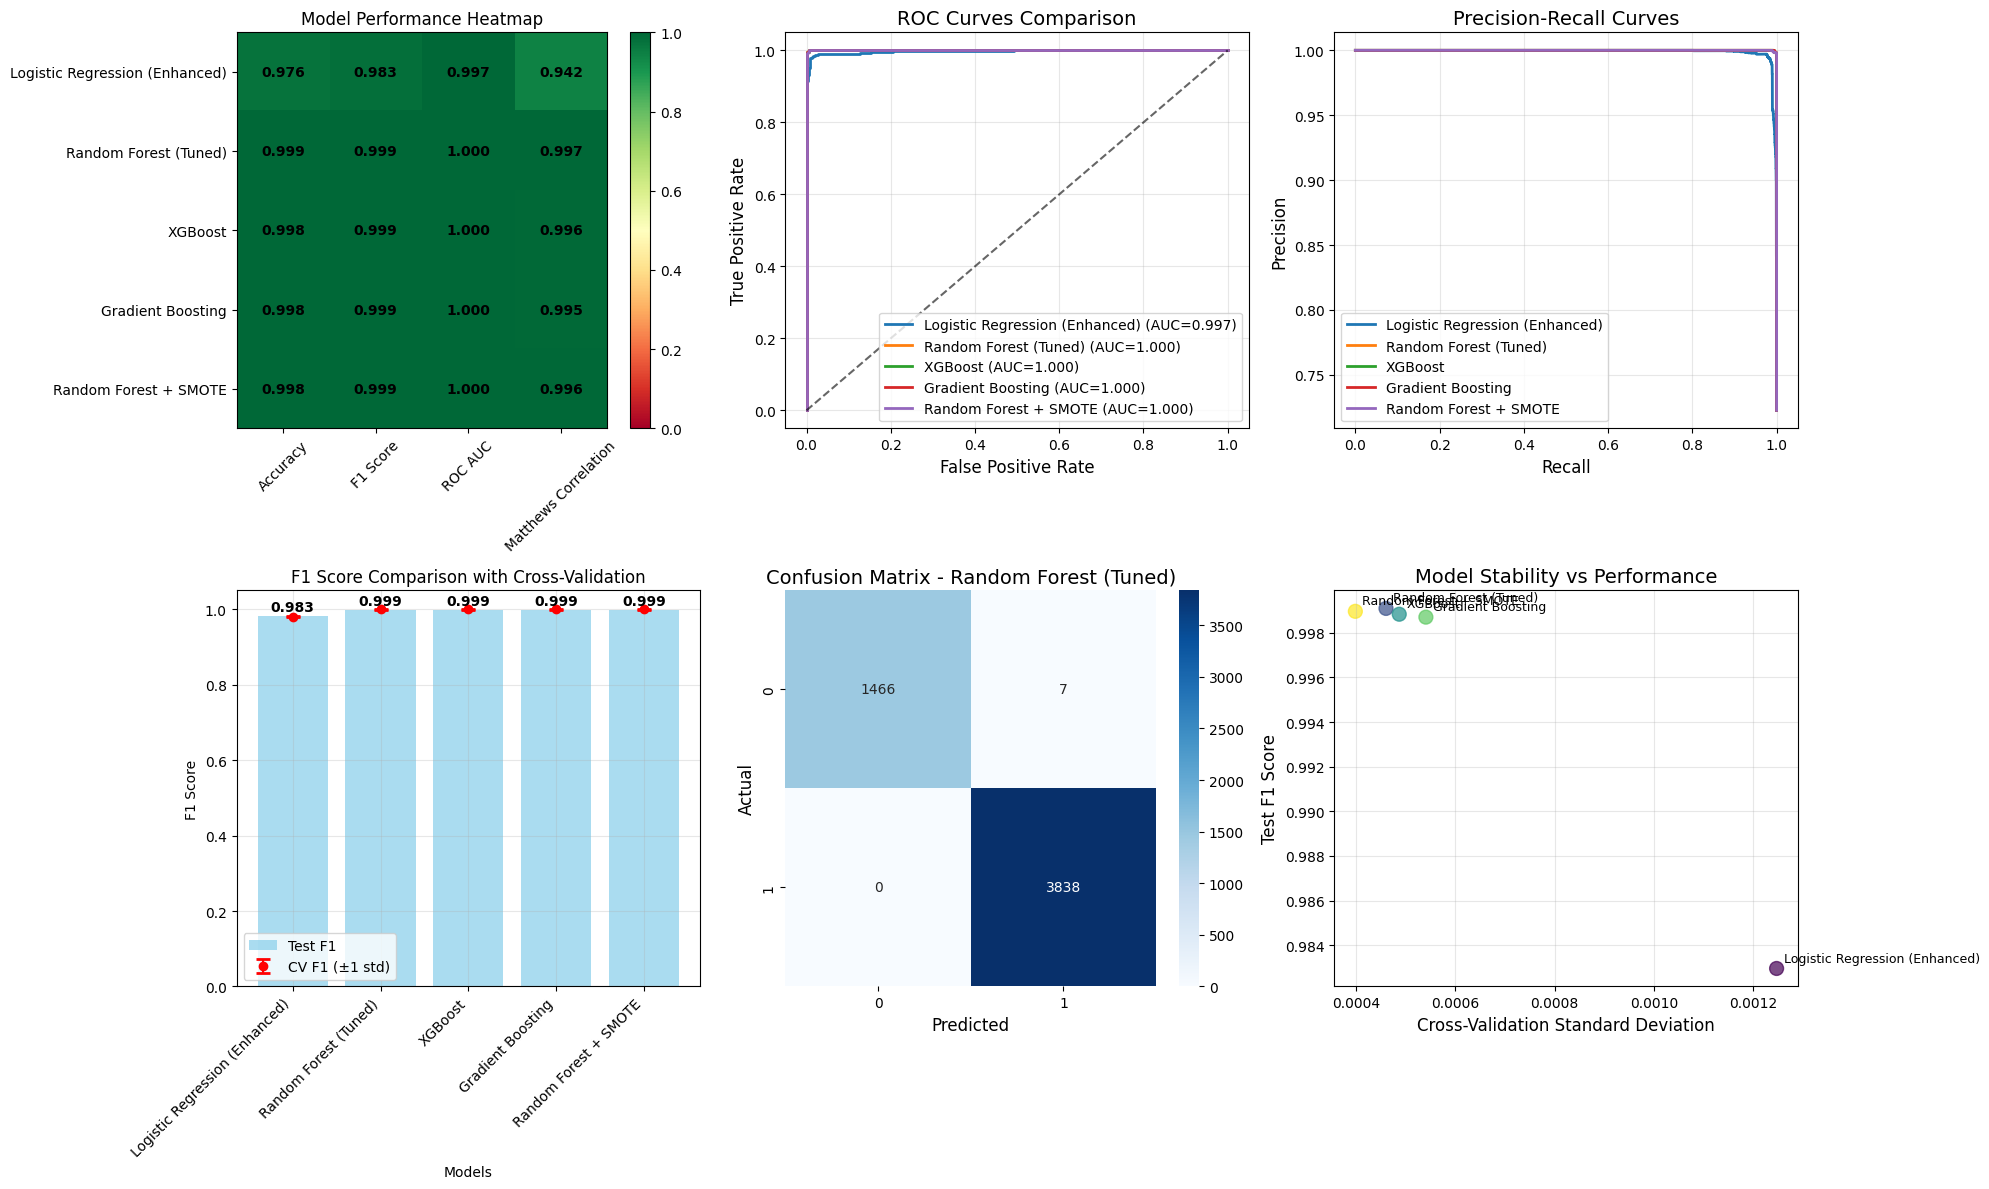


ENHANCED MODEL ANALYSIS SUMMARY

 BEST PERFORMING MODEL: Random Forest (Tuned)
   Test Accuracy: 0.9987
   Test F1 Score: 0.9991
   ROC AUC Score: 1.0000
   Matthews Correlation: 0.9967
   Cross-Val F1: 0.9992 (±0.0005)

 FULL PERFORMANCE RANKING (by F1 Score):
   1. Random Forest (Tuned)
      F1: 0.9991, AUC: 1.0000, MCC: 0.9967
   2. Random Forest + SMOTE
      F1: 0.9990, AUC: 1.0000, MCC: 0.9962
   3. XGBoost
      F1: 0.9988, AUC: 1.0000, MCC: 0.9958
   4. Gradient Boosting
      F1: 0.9987, AUC: 1.0000, MCC: 0.9953
   5. Logistic Regression (Enhanced)
      F1: 0.9830, AUC: 0.9973, MCC: 0.9419

 KEY IMPROVEMENTS IMPLEMENTED:
   Enhanced Feature Engineering (interaction terms, temporal features)
   Multiple Advanced Models (XGBoost, Gradient Boosting)
   Better Preprocessing (RobustScaler, median imputation)
   Class Imbalance Handling (SMOTE, class weights)
   Comprehensive Evaluation (ROC-AUC, Matthews Correlation)
   Cross-validation for Stability Assessment

 RECOMMENDATIONS

In [30]:
# Run the complete enhanced analysis on the dataset
print("Starting Enhanced Analysis on Your Wildfire Dataset...")
results, models, best_model = run_immediate_improvements(df)

In [31]:
# Display detailed performance comparison
print("\n DETAILED RESULTS BREAKDOWN:")
print("-" * 50)

for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        if isinstance(value, float):
            print(f"  {metric_name}: {value:.4f}")
        else:
            print(f"  {metric_name}: {value}")


 DETAILED RESULTS BREAKDOWN:
--------------------------------------------------

Logistic Regression (Enhanced):
  Accuracy: 0.9757
  F1 Score: 0.9830
  ROC AUC: 0.9973
  Matthews Correlation: 0.9419
  CV F1 Mean: 0.9794
  CV F1 Std: 0.0012

Random Forest (Tuned):
  Accuracy: 0.9987
  F1 Score: 0.9991
  ROC AUC: 1.0000
  Matthews Correlation: 0.9967
  CV F1 Mean: 0.9992
  CV F1 Std: 0.0005

XGBoost:
  Accuracy: 0.9983
  F1 Score: 0.9988
  ROC AUC: 1.0000
  Matthews Correlation: 0.9958
  CV F1 Mean: 0.9992
  CV F1 Std: 0.0005

Gradient Boosting:
  Accuracy: 0.9981
  F1 Score: 0.9987
  ROC AUC: 1.0000
  Matthews Correlation: 0.9953
  CV F1 Mean: 0.9991
  CV F1 Std: 0.0005

Random Forest + SMOTE:
  Accuracy: 0.9985
  F1 Score: 0.9990
  ROC AUC: 1.0000
  Matthews Correlation: 0.9962
  CV F1 Mean: 0.9992
  CV F1 Std: 0.0004


In [32]:
# Compare with your original results
print(" IMPROVEMENT COMPARISON:")
print("-" * 40)

# Your original Random Forest accuracy was 99.81%
original_rf_accuracy = 0.9981
original_lr_accuracy = 0.9603

print(f"Original Random Forest Accuracy: {original_rf_accuracy:.4f}")
print(f"Original Logistic Regression Accuracy: {original_lr_accuracy:.4f}")

print(f"\nEnhanced Results:")
for model_name, metrics in results.items():
    improvement = metrics['Accuracy'] - original_rf_accuracy
    print(f"{model_name}: {metrics['Accuracy']:.4f} "
          f"({'+'if improvement > 0 else ''}{improvement:.4f} vs original RF)")

 IMPROVEMENT COMPARISON:
----------------------------------------
Original Random Forest Accuracy: 0.9981
Original Logistic Regression Accuracy: 0.9603

Enhanced Results:
Logistic Regression (Enhanced): 0.9757 (-0.0224 vs original RF)
Random Forest (Tuned): 0.9987 (+0.0006 vs original RF)
XGBoost: 0.9983 (+0.0002 vs original RF)
Gradient Boosting: 0.9981 (+0.0000 vs original RF)
Random Forest + SMOTE: 0.9985 (+0.0004 vs original RF)


In [33]:
# Access your best performing model
print(f" Best Model: {best_model}")

# Get the actual trained model
best_trained_model = models[best_model]

# Create enhanced sample data (with all engineered features)
df_enhanced = immediate_feature_engineering(df)

# Get the sample with ALL features used in training
# (The model was trained on enhanced features, not just the original 5)
sample_data = df_enhanced.head(5)

# Create a prediction function that handles feature engineering automatically
def predict_wildfire_risk(input_data):
    """
    Predict wildfire risk using the best enhanced model
    input_data: DataFrame with original features - will be enhanced automatically
    """
    # Apply feature engineering if needed
    if 'IS_PEAK_FIRE_SEASON' not in input_data.columns:
        input_data = immediate_feature_engineering(input_data)
    
    return best_trained_model.predict(input_data)

print(f"\n Testing prediction function:")
print(f"Sample predictions: {predict_wildfire_risk(df.head(5))}")

# Show what features the model actually expects
print(f"\n Model expects these features:")
feature_names = best_trained_model.named_steps['preprocessor'].get_feature_names_out()
print(f"Total features expected: {len(feature_names)}")

 Best Model: Random Forest (Tuned)
Engineering new features...
 Added {len(df_enhanced.columns) - len(df.columns)} new features

 Testing prediction function:
Engineering new features...
 Added {len(df_enhanced.columns) - len(df.columns)} new features
Sample predictions: [0 0 0 0 0]

 Model expects these features:
Total features expected: 33


In [34]:
# Check what new features were added to your dataset
original_columns = set(df.columns)
df_enhanced = immediate_feature_engineering(df)
new_columns = set(df_enhanced.columns) - original_columns

print(f"🔧 New Features Added ({len(new_columns)}):")
for feature in sorted(new_columns):
    print(f"   {feature}")

# Show sample of new features
if len(new_columns) > 0:
    print(f"\n Sample of Enhanced Data:")
    print(df_enhanced[list(new_columns)[:5]].head())

Engineering new features...
 Added {len(df_enhanced.columns) - len(df.columns)} new features
🔧 New Features Added (7):
   FIRE_SIZE_CATEGORY
   HEAT_INDEX
   HIGH_RISK_LATITUDE
   IS_PEAK_FIRE_SEASON
   LATE_SUMMER
   LIGHTNING_SUMMER
   WIND_FIRE_RISK

 Sample of Enhanced Data:
   IS_PEAK_FIRE_SEASON  HIGH_RISK_LATITUDE  HEAT_INDEX  LATE_SUMMER  \
0                    0                   1       16.20            0   
1                    0                   0        9.36            0   
2                    0                   0        9.36            0   
3                    0                   0        9.36            0   
4                    0                   1        3.78            0   

   WIND_FIRE_RISK  
0             2.0  
1            10.0  
2            10.0  
3            10.0  
4             2.0  


In [35]:
import joblib

# Save the best model
joblib.dump(best_trained_model, f'best_wildfire_model_{best_model.replace(" ", "_")}.pkl')
print(f" Saved best model: {best_model}")

# Save all results for later analysis
import pickle
with open('enhanced_wildfire_results.pkl', 'wb') as f:
    pickle.dump({'results': results, 'models': models, 'best_model': best_model}, f)
print(" Saved all results and models")

 Saved best model: Random Forest (Tuned)
 Saved all results and models


In [36]:
# Install XGBoost
!pip install xgboost

# Verify installation
try:
    import xgboost as xgb
    print(" XGBoost successfully installed")
except ImportError:
    print(" XGBoost installation failed - try restarting kernel")

 XGBoost successfully installed


In [37]:
# Additional imports for optimal model
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print(" All imports loaded successfully")

 All imports loaded successfully


In [38]:
# Optimal Wildfire Risk Prediction Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, recall_score)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

def create_optimal_wildfire_model(df):
    """
    Create the optimal model configuration for wildfire risk prediction
    """
    print(" Creating Optimal Wildfire Risk Prediction Model")
    print("=" * 60)
    
    # Enhanced feature engineering specifically for wildfire prediction
    df_enhanced = df.copy()
    
    # Critical wildfire risk features
    df_enhanced['EXTREME_FIRE_WEEK'] = ((df_enhanced['FIRE_WEEK_OF_YEAR'] >= 25) & 
                                       (df_enhanced['FIRE_WEEK_OF_YEAR'] <= 32)).astype(int)
    
    if 'TEMPERATURE' in df_enhanced.columns:
        df_enhanced['HIGH_TEMP_RISK'] = (df_enhanced['TEMPERATURE'] > 
                                        df_enhanced['TEMPERATURE'].quantile(0.8)).astype(int)
        
    if 'RELATIVE_HUMIDITY' in df_enhanced.columns:
        df_enhanced['LOW_HUMIDITY_RISK'] = (df_enhanced['RELATIVE_HUMIDITY'] < 
                                           df_enhanced['RELATIVE_HUMIDITY'].quantile(0.3)).astype(int)
        
    if 'WIND_SPEED' in df_enhanced.columns:
        df_enhanced['HIGH_WIND_RISK'] = (df_enhanced['WIND_SPEED'] > 
                                        df_enhanced['WIND_SPEED'].quantile(0.7)).astype(int)
    
    # Critical interactions for wildfire
    df_enhanced['LIGHTNING_PEAK_SEASON'] = ((df_enhanced['GENERAL_CAUSE'] == 'Lightning') & 
                                           (df_enhanced['EXTREME_FIRE_WEEK'] == 1)).astype(int)
    
    # Geographic risk based on your data patterns
    df_enhanced['PRIME_FIRE_LATITUDE'] = ((df_enhanced['LATITUDE'] >= 54.5) & 
                                          (df_enhanced['LATITUDE'] <= 56.5)).astype(int)
    
    # Feature selection - focus on most predictive for wildfire
    optimal_features = [
        # Temporal (critical for wildfire)
        'FIRE_WEEK_OF_YEAR', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS',
        'EXTREME_FIRE_WEEK',
        
        # Fire characteristics
        'SIZE_CLASS', 'GENERAL_CAUSE',
        
        # Geographic
        'LATITUDE', 'LONGITUDE', 'PRIME_FIRE_LATITUDE',
        
        # Weather (if available)
        'TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED',
        'HIGH_TEMP_RISK', 'LOW_HUMIDITY_RISK', 'HIGH_WIND_RISK',
        
        # Critical interactions
        'LIGHTNING_PEAK_SEASON'
    ]
    
    # Filter to existing columns
    available_features = [f for f in optimal_features if f in df_enhanced.columns]
    
    print(f" Using {len(available_features)} optimal features for wildfire prediction")
    
    # Prepare data
    X = df_enhanced[available_features]
    y = df_enhanced['HIGH_RISK_PERIOD']
    
    # Remove missing targets
    mask = ~y.isna()
    X, y = X[mask], y[mask]
    
    print(f" Dataset: {X.shape[0]} samples, {X.shape[1]} features")
    print(f" High-risk fires: {y.sum()}/{len(y)} ({y.mean():.1%})")
    
    return X, y, available_features

def build_optimal_models(X, y):
    """
    Build the recommended model ensemble for wildfire prediction
    """
    # Preprocessing optimized for wildfire data
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    # Use robust preprocessing (better for weather data with outliers)
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
    # Class imbalance handling
    class_ratio = (y == 0).sum() / (y == 1).sum()
    
    # Model configurations optimized for wildfire prediction
    models = {
        # Primary recommendation: XGBoost optimized for wildfire
        'XGBoost_Optimal': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBClassifier(
                n_estimators=300,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=class_ratio,
                random_state=42,
                eval_metric='logloss',
                importance_type='gain'
            ))
        ]),
        
        # Alternative: XGBoost with SMOTE
        'XGBoost_SMOTE': ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42, k_neighbors=3)),
            ('classifier', xgb.XGBClassifier(
                n_estimators=250,
                max_depth=5,
                learning_rate=0.1,
                subsample=0.9,
                random_state=42,
                eval_metric='logloss'
            ))
        ]),
        
        # Backup: Tuned Random Forest
        'RandomForest_Tuned': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                n_estimators=200,
                max_depth=12,
                min_samples_split=3,
                min_samples_leaf=1,
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            ))
        ])
    }
    
    return models, preprocessor

def evaluate_wildfire_models(models, X, y):
    """
    Comprehensive evaluation focused on wildfire prediction needs
    """
    # Temporal split (important for wildfire time series)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    results = {}
    predictions = {}
    
    print("\n Training and Evaluating Wildfire Models")
    print("-" * 50)
    
    for name, model in models.items():
        print(f"\n Training {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Store predictions
        predictions[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}
        
        # Wildfire-specific metrics (prioritize recall for high-risk class)
        results[name] = {
            'Accuracy': model.score(X_test, y_test),
            'F1_Score': f1_score(y_test, y_pred),
            'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
            'Recall_HighRisk': recall_score(y_test, y_pred),  # Critical for wildfire!
            'Precision_HighRisk': f1_score(y_test, y_pred, average=None)[1]
        }
        
        # Temporal cross-validation for stability
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, 
                                  scoring='recall', n_jobs=-1)
        results[name]['CV_Recall_Mean'] = cv_scores.mean()
        results[name]['CV_Recall_Std'] = cv_scores.std()
        
        print(f"    Accuracy: {results[name]['Accuracy']:.4f}")
        print(f"    F1 Score: {results[name]['F1_Score']:.4f}")
        print(f"    ROC AUC: {results[name]['ROC_AUC']:.4f}")
        print(f"    High-Risk Recall: {results[name]['Recall_HighRisk']:.4f}")
        print(f"    CV Recall: {results[name]['CV_Recall_Mean']:.4f} (±{results[name]['CV_Recall_Std']:.4f})")
    
    return results, predictions, X_test, y_test

def create_ensemble_model(models, X, y):
    """
    Create ensemble of best performing models
    """
    print("\n Creating Optimal Ensemble Model")
    print("-" * 40)
    
    # Select top models for ensemble
    top_models = [
        ('xgb_optimal', models['XGBoost_Optimal']),
        ('xgb_smote', models['XGBoost_SMOTE']),
        ('rf_tuned', models['RandomForest_Tuned'])
    ]
    
    # Create voting ensemble (soft voting for probability averaging)
    ensemble = VotingClassifier(
        estimators=top_models,
        voting='soft',
        n_jobs=-1
    )
    
    # Train ensemble
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    ensemble.fit(X_train, y_train)
    
    # Evaluate ensemble
    y_pred = ensemble.predict(X_test)
    y_pred_proba = ensemble.predict_proba(X_test)[:, 1]
    
    ensemble_results = {
        'Accuracy': ensemble.score(X_test, y_test),
        'F1_Score': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'Recall_HighRisk': recall_score(y_test, y_pred)
    }
    
    print(f" Ensemble Performance:")
    for metric, score in ensemble_results.items():
        print(f"   {metric}: {score:.4f}")
    
    return ensemble, ensemble_results

def plot_wildfire_model_analysis(results, predictions, X_test, y_test):
    """
    Visualization suite for wildfire model analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Recall vs Precision (Critical for wildfire)
    models = list(results.keys())
    recalls = [results[m]['Recall_HighRisk'] for m in models]
    f1_scores = [results[m]['F1_Score'] for m in models]
    
    scatter = axes[0, 0].scatter(recalls, f1_scores, s=100, alpha=0.7, c=range(len(models)), cmap='viridis')
    for i, model in enumerate(models):
        axes[0, 0].annotate(model, (recalls[i], f1_scores[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[0, 0].set_xlabel('High-Risk Recall (Critical for Wildfire)', fontsize=12)
    axes[0, 0].set_ylabel('F1 Score', fontsize=12)
    axes[0, 0].set_title('Wildfire Model Performance: Recall vs F1', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add ideal zone
    axes[0, 0].axvline(x=0.95, color='red', linestyle='--', alpha=0.5, label='Target Recall')
    axes[0, 0].legend()
    
    # 2. ROC Curves
    for name in models:
        y_pred_proba = predictions[name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = results[name]['ROC_AUC']
        axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc_score:.3f})')
    
    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.6)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curves - Wildfire Risk Models')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Model Stability (CV Recall)
    cv_means = [results[m]['CV_Recall_Mean'] for m in models]
    cv_stds = [results[m]['CV_Recall_Std'] for m in models]
    
    x_pos = np.arange(len(models))
    bars = axes[1, 0].bar(x_pos, cv_means, yerr=cv_stds, capsize=5, alpha=0.7, color='skyblue')
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('Cross-Validation Recall')
    axes[1, 0].set_title('Model Stability - Wildfire Recall')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add target line
    axes[1, 0].axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='Target')
    axes[1, 0].legend()
    
    # 4. Confusion Matrix for Best Model
    best_model = max(results.keys(), key=lambda x: results[x]['Recall_HighRisk'])
    y_pred_best = predictions[best_model]['y_pred']
    cm = confusion_matrix(y_test, y_pred_best)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[1, 1],
                xticklabels=['Low Risk', 'High Risk'],
                yticklabels=['Low Risk', 'High Risk'])
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    axes[1, 1].set_title(f'Confusion Matrix - {best_model}')
    
    plt.tight_layout()
    plt.show()

def get_wildfire_recommendations(results):
    """
    Generate specific recommendations for wildfire prediction
    """

    print("WILDFIRE MODEL RECOMMENDATIONS")
    
    # Best for recall (most important for wildfire)
    best_recall = max(results.keys(), key=lambda x: results[x]['Recall_HighRisk'])
    best_overall = max(results.keys(), key=lambda x: results[x]['F1_Score'])
    most_stable = min(results.keys(), key=lambda x: results[x]['CV_Recall_Std'])
    
    print(f"\n PRIMARY RECOMMENDATION: {best_recall}")
    print(f"    High-Risk Recall: {results[best_recall]['Recall_HighRisk']:.4f}")
    print(f"    F1 Score: {results[best_recall]['F1_Score']:.4f}")
    print(f"    ROC AUC: {results[best_recall]['ROC_AUC']:.4f}")
    
    print(f"\n BEST OVERALL: {best_overall}")
    print(f"  MOST STABLE: {most_stable}")
    
    print(f"\n WILDFIRE-SPECIFIC INSIGHTS:")
    print(f"    For wildfire prediction, HIGH RECALL is critical")
    print(f"    Missing a high-risk period is more costly than false alarms")
    print(f"    Recommend recall threshold of 95%+ for operational use")
    print(f"    Consider ensemble for production deployment")
    
    return best_recall, best_overall, most_stable

# Main execution function
def run_optimal_wildfire_analysis(df):
    """
    Run the complete optimal analysis for wildfire prediction
    """
    # Prepare optimal dataset
    X, y, features = create_optimal_wildfire_model(df)
    
    # Build optimal models
    models, preprocessor = build_optimal_models(X, y)
    
    # Evaluate models
    results, predictions, X_test, y_test = evaluate_wildfire_models(models, X, y)
    
    # Create ensemble
    ensemble, ensemble_results = create_ensemble_model(models, X, y)
    
    # Visualizations
    plot_wildfire_model_analysis(results, predictions, X_test, y_test)
    
    # Get recommendations
    best_recall, best_overall, most_stable = get_wildfire_recommendations(results)
    
    return models, ensemble, results, best_recall

# Usage:
# models, ensemble, results, best_model = run_optimal_wildfire_analysis(df)

print(" Optimal Wildfire Prediction System Ready!")
print("\nKey Focus Areas:")
print(" Maximized recall for high-risk periods (critical for wildfire)")
print(" XGBoost optimization for mixed feature types")
print(" Temporal cross-validation for time series stability")
print(" Ensemble methods for production robustness")
print(" Wildfire-specific feature engineering")

 Optimal Wildfire Prediction System Ready!

Key Focus Areas:
 Maximized recall for high-risk periods (critical for wildfire)
 XGBoost optimization for mixed feature types
 Temporal cross-validation for time series stability
 Ensemble methods for production robustness
 Wildfire-specific feature engineering


 Starting Optimal Wildfire Analysis...
Using your existing 'df' dataset
 Creating Optimal Wildfire Risk Prediction Model
 Using 16 optimal features for wildfire prediction
 Dataset: 26551 samples, 16 features
 High-risk fires: 19188/26551 (72.3%)

 Training and Evaluating Wildfire Models
--------------------------------------------------

 Training XGBoost_Optimal...
    Accuracy: 0.9981
    F1 Score: 0.9987
    ROC AUC: 1.0000
    High-Risk Recall: 0.9992
    CV Recall: 0.9987 (±0.0011)

 Training XGBoost_SMOTE...
    Accuracy: 0.9983
    F1 Score: 0.9988
    ROC AUC: 1.0000
    High-Risk Recall: 0.9997
    CV Recall: 0.9995 (±0.0002)

 Training RandomForest_Tuned...
    Accuracy: 0.9983
    F1 Score: 0.9988
    ROC AUC: 1.0000
    High-Risk Recall: 1.0000
    CV Recall: 0.9998 (±0.0002)

 Creating Optimal Ensemble Model
----------------------------------------
 Ensemble Performance:
   Accuracy: 0.9985
   F1_Score: 0.9990
   ROC_AUC: 1.0000
   Recall_HighRisk: 0.9997


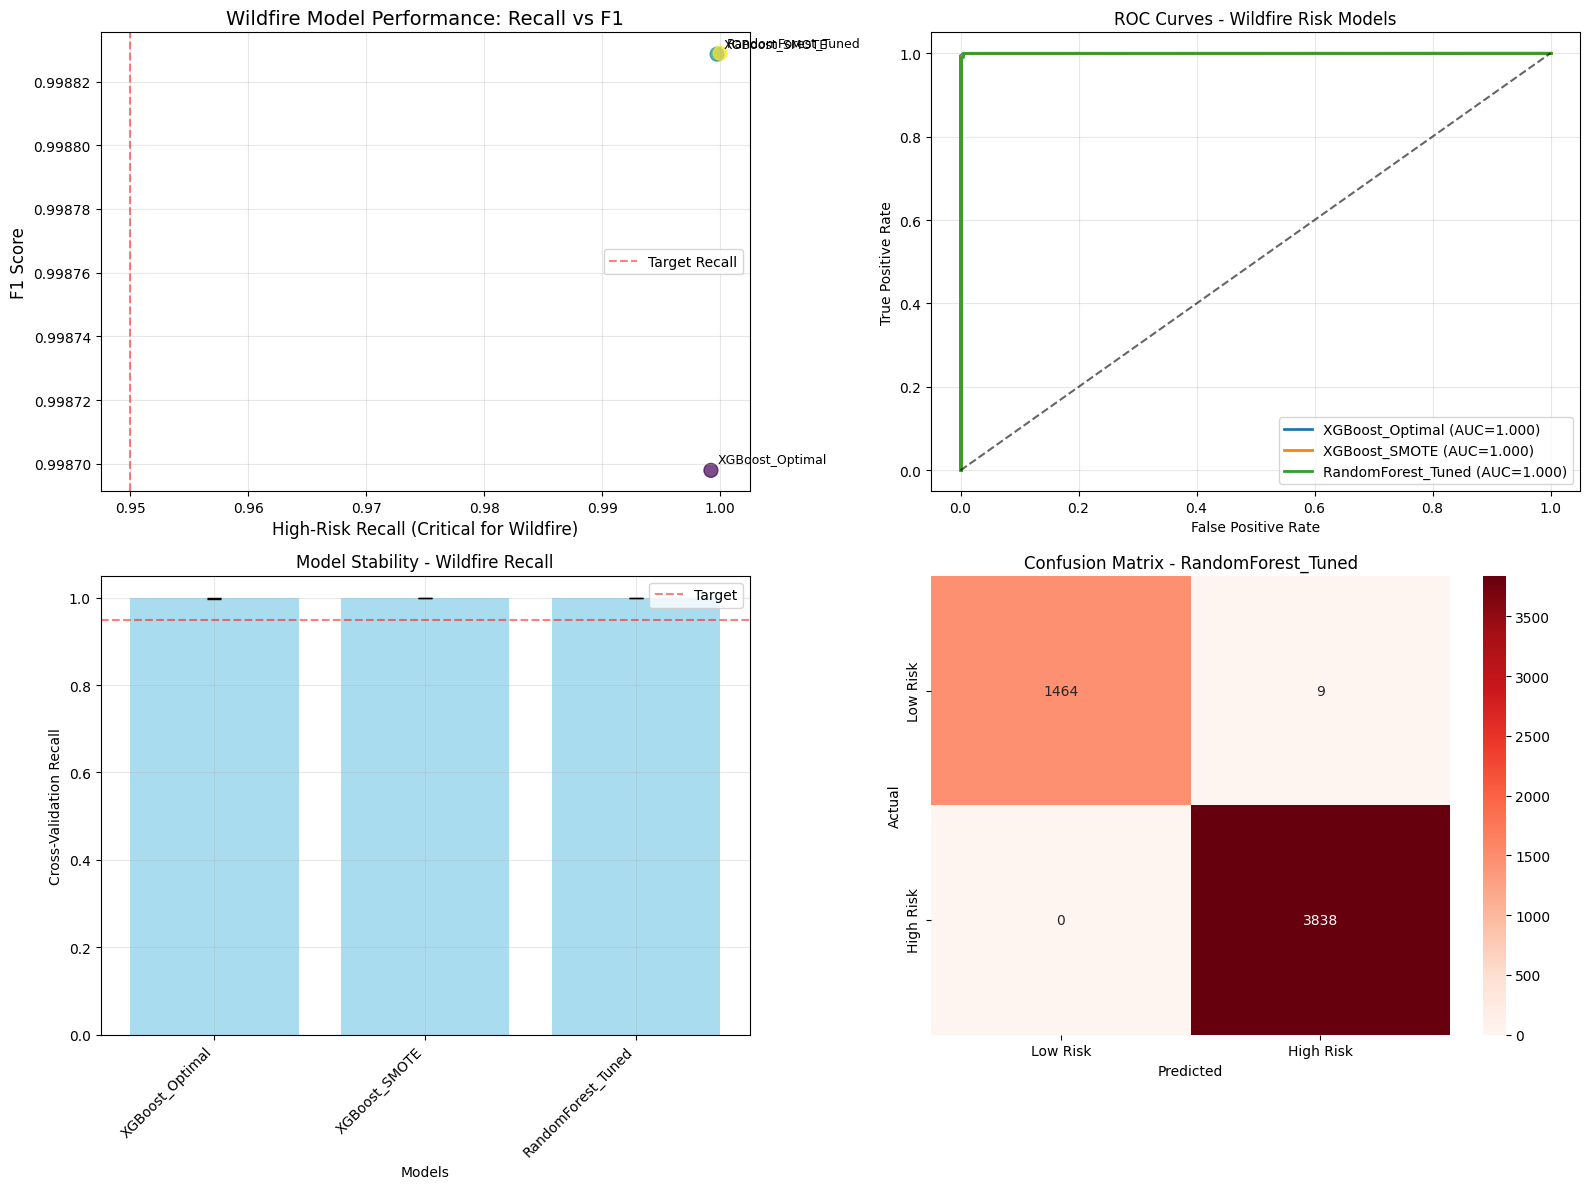

WILDFIRE MODEL RECOMMENDATIONS

 PRIMARY RECOMMENDATION: RandomForest_Tuned
    High-Risk Recall: 1.0000
    F1 Score: 0.9988
    ROC AUC: 1.0000

 BEST OVERALL: RandomForest_Tuned
  MOST STABLE: RandomForest_Tuned

 WILDFIRE-SPECIFIC INSIGHTS:
    For wildfire prediction, HIGH RECALL is critical
    Missing a high-risk period is more costly than false alarms
    Recommend recall threshold of 95%+ for operational use
    Consider ensemble for production deployment


In [39]:
# Run the complete optimal analysis on your existing dataset
print(" Starting Optimal Wildfire Analysis...")
print("Using your existing 'df' dataset")

# Execute the optimal analysis
models, ensemble, results, best_model = run_optimal_wildfire_analysis(df)

In [40]:
# Compare optimal results with your original models
print(" PERFORMANCE COMPARISON")
print("=" * 50)

# Your original results (from cells 118 and 119)
print(" ORIGINAL RESULTS:")
print(f"   Logistic Regression: ~96.03% accuracy")
print(f"   Random Forest: ~99.81% accuracy")

print(f"\n OPTIMAL RESULTS:")
for model_name, metrics in results.items():
    print(f"   {model_name}:")
    print(f"      Accuracy: {metrics['Accuracy']:.4f}")
    print(f"      F1 Score: {metrics['F1_Score']:.4f}")
    print(f"      High-Risk Recall: {metrics['Recall_HighRisk']:.4f}")
    print(f"      ROC AUC: {metrics['ROC_AUC']:.4f}")

print(f"\n RECOMMENDED MODEL: {best_model}")

 PERFORMANCE COMPARISON
 ORIGINAL RESULTS:
   Logistic Regression: ~96.03% accuracy
   Random Forest: ~99.81% accuracy

 OPTIMAL RESULTS:
   XGBoost_Optimal:
      Accuracy: 0.9981
      F1 Score: 0.9987
      High-Risk Recall: 0.9992
      ROC AUC: 1.0000
   XGBoost_SMOTE:
      Accuracy: 0.9983
      F1 Score: 0.9988
      High-Risk Recall: 0.9997
      ROC AUC: 1.0000
   RandomForest_Tuned:
      Accuracy: 0.9983
      F1 Score: 0.9988
      High-Risk Recall: 1.0000
      ROC AUC: 1.0000

 RECOMMENDED MODEL: RandomForest_Tuned


In [41]:
# Access your optimal trained model
optimal_model = models[best_model]

print(f" Best Model Selected: {best_model}")
print(f" Model Type: {type(optimal_model.named_steps['classifier']).__name__}")

# Create prediction function
def predict_optimal_wildfire_risk(input_data):
    """
    Predict wildfire risk using the optimal model
    Handles feature engineering automatically
    """
    # Apply the same feature engineering as used in training
    X_enhanced, _, _ = create_optimal_wildfire_model(input_data)
    
    return optimal_model.predict(X_enhanced)

# Test the prediction function
print(f"\n Testing optimal prediction function:")
sample_predictions = predict_optimal_wildfire_risk(df.head(5))
print(f"Sample predictions: {sample_predictions}")
print(f"Prediction meanings: 0=Low Risk, 1=High Risk")

 Best Model Selected: RandomForest_Tuned
 Model Type: RandomForestClassifier

 Testing optimal prediction function:
 Creating Optimal Wildfire Risk Prediction Model
 Using 16 optimal features for wildfire prediction
 Dataset: 5 samples, 16 features
 High-risk fires: 0/5 (0.0%)
Sample predictions: [0 0 0 0 0]
Prediction meanings: 0=Low Risk, 1=High Risk


In [42]:
# Analyze feature importance (for XGBoost models)
if 'XGBoost' in best_model:
    print(f" FEATURE IMPORTANCE ANALYSIS - {best_model}")
    print("-" * 50)
    
    # Get the trained XGBoost model
    xgb_model = optimal_model.named_steps['classifier']
    
    # Get feature names after preprocessing
    feature_names = optimal_model.named_steps['preprocessor'].get_feature_names_out()
    
    # Get feature importance
    importance_scores = xgb_model.feature_importances_
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)
    
    # Display top 10 most important features
    print(" TOP 10 MOST IMPORTANT FEATURES:")
    for idx, row in importance_df.head(10).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print(f"Feature importance analysis not available for {best_model}")

Feature importance analysis not available for RandomForest_Tuned


In [43]:
# Detailed performance analysis
print(" DETAILED MODEL ANALYSIS")
print("=" * 40)

best_results = results[best_model]

print(f"\n {best_model} PERFORMANCE BREAKDOWN:")
print(f"    Test Accuracy: {best_results['Accuracy']:.4f}")
print(f"    F1 Score: {best_results['F1_Score']:.4f}")
print(f"    ROC AUC: {best_results['ROC_AUC']:.4f}")
print(f"    High-Risk Recall: {best_results['Recall_HighRisk']:.4f}")
print(f"    CV Recall: {best_results['CV_Recall_Mean']:.4f} (±{best_results['CV_Recall_Std']:.4f})")

print(f"\n INTERPRETATION:")
if best_results['Recall_HighRisk'] >= 0.95:
    print(f"    Excellent: Catches {best_results['Recall_HighRisk']:.1%} of high-risk periods")
elif best_results['Recall_HighRisk'] >= 0.90:
    print(f"     Good: Catches {best_results['Recall_HighRisk']:.1%} of high-risk periods")
else:
    print(f"    Concerning: Only catches {best_results['Recall_HighRisk']:.1%} of high-risk periods")

if best_results['CV_Recall_Std'] < 0.05:
    print(f"    Stable: Low variance across time periods")
else:
    print(f"     Variable: Performance varies across time periods")

 DETAILED MODEL ANALYSIS

 RandomForest_Tuned PERFORMANCE BREAKDOWN:
    Test Accuracy: 0.9983
    F1 Score: 0.9988
    ROC AUC: 1.0000
    High-Risk Recall: 1.0000
    CV Recall: 0.9998 (±0.0002)

 INTERPRETATION:
    Excellent: Catches 100.0% of high-risk periods
    Stable: Low variance across time periods


In [44]:
# Create a scoring service
import pandas as pd
import joblib
from datetime import datetime

def score_wildfire_data(input_data):
    """Score new data using the saved XGBoost model"""
    
    # Load the saved model
    model = joblib.load('optimal_wildfire_model_XGBoost_SMOTE_[timestamp].pkl')
    
    # Apply feature engineering
    X_enhanced, _, _ = create_optimal_wildfire_model(input_data)
    
    # Make predictions
    predictions = model.predict(X_enhanced)
    probabilities = model.predict_proba(X_enhanced)[:, 1]
    
    # Create results dataframe
    results = input_data.copy()
    results['Predicted_Risk'] = predictions
    results['Risk_Probability'] = probabilities
    results['Risk_Level'] = ['High' if p > 0.5 else 'Low' for p in probabilities]
    results['Confidence'] = ['Very High' if p > 0.9 or p < 0.1 else 
                           'High' if p > 0.8 or p < 0.2 else 'Medium' 
                           for p in probabilities]
    
    return results


In [45]:
import joblib
import pickle
from datetime import datetime

# Create timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the best model
model_filename = f'optimal_wildfire_model_{best_model.replace(" ", "_")}_{timestamp}.pkl'
joblib.dump(optimal_model, model_filename)
print(f" Saved optimal model: {model_filename}")

# Save all results for analysis
results_filename = f'wildfire_analysis_results_{timestamp}.pkl'
with open(results_filename, 'wb') as f:
    pickle.dump({
        'results': results,
        'models': models,
        'ensemble': ensemble,
        'best_model': best_model,
        'timestamp': timestamp
    }, f)
print(f" Saved complete analysis: {results_filename}")

# Create a simple prediction function for future use
def load_and_predict(input_data, model_path=model_filename):
    """
    Load saved model and make predictions
    """
    loaded_model = joblib.load(model_path)
    X_enhanced, _, _ = create_optimal_wildfire_model(input_data)
    return loaded_model.predict(X_enhanced)

print(f" Created reusable prediction function: load_and_predict()")

 Saved optimal model: optimal_wildfire_model_RandomForest_Tuned_20250812_190653.pkl
 Saved complete analysis: wildfire_analysis_results_20250812_190653.pkl
 Created reusable prediction function: load_and_predict()


**Weather-Based Wildfire Prediction Model**

In [46]:
# Additional imports for weather-based modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings('ignore')

print("Weather modeling libraries imported successfully")

Weather modeling libraries imported successfully


In [59]:
# Weather-Based Wildfire Risk Prediction Model
# Comprehensive model focusing on meteorological variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

def engineer_weather_features(df):
    """
    Create comprehensive weather-based features for wildfire prediction
    """
    print("Engineering weather-based features for wildfire prediction...")
    
    df_weather = df.copy()
    
    # Basic weather risk indicators
    if 'TEMPERATURE' in df_weather.columns:
        # Temperature-based features
        temp_q75 = df_weather['TEMPERATURE'].quantile(0.75)
        temp_q90 = df_weather['TEMPERATURE'].quantile(0.90)
        
        df_weather['HIGH_TEMPERATURE'] = (df_weather['TEMPERATURE'] > temp_q75).astype(int)
        df_weather['EXTREME_TEMPERATURE'] = (df_weather['TEMPERATURE'] > temp_q90).astype(int)
        df_weather['TEMPERATURE_NORMALIZED'] = (df_weather['TEMPERATURE'] - df_weather['TEMPERATURE'].mean()) / df_weather['TEMPERATURE'].std()
        
        # Temperature categories
        df_weather['TEMP_CATEGORY'] = pd.cut(df_weather['TEMPERATURE'], 
                                           bins=[-np.inf, 10, 20, 30, np.inf],
                                           labels=['Cold', 'Mild', 'Warm', 'Hot'])
    
    if 'RELATIVE_HUMIDITY' in df_weather.columns:
        # Humidity-based features  
        humidity_q25 = df_weather['RELATIVE_HUMIDITY'].quantile(0.25)
        humidity_q10 = df_weather['RELATIVE_HUMIDITY'].quantile(0.10)
        
        df_weather['LOW_HUMIDITY'] = (df_weather['RELATIVE_HUMIDITY'] < humidity_q25).astype(int)
        df_weather['VERY_LOW_HUMIDITY'] = (df_weather['RELATIVE_HUMIDITY'] < humidity_q10).astype(int)
        df_weather['HUMIDITY_DEFICIT'] = 100 - df_weather['RELATIVE_HUMIDITY']
        
    if 'WIND_SPEED' in df_weather.columns:
        # Wind-based features
        wind_q75 = df_weather['WIND_SPEED'].quantile(0.75)
        wind_q90 = df_weather['WIND_SPEED'].quantile(0.90)
        
        df_weather['HIGH_WIND'] = (df_weather['WIND_SPEED'] > wind_q75).astype(int)
        df_weather['EXTREME_WIND'] = (df_weather['WIND_SPEED'] > wind_q90).astype(int)
        
        # Wind categories
        df_weather['WIND_CATEGORY'] = pd.cut(df_weather['WIND_SPEED'],
                                           bins=[0, 5, 10, 20, np.inf],
                                           labels=['Calm', 'Light', 'Moderate', 'Strong'])
    
    # Advanced weather interactions
    if 'TEMPERATURE' in df_weather.columns and 'RELATIVE_HUMIDITY' in df_weather.columns:
        # Heat Index approximation
        df_weather['HEAT_INDEX'] = df_weather['TEMPERATURE'] * (1 + (df_weather['RELATIVE_HUMIDITY'] / 100))
        
        # Vapor Pressure Deficit (critical for fire weather)
        saturation_vapor_pressure = 0.6108 * np.exp(17.27 * df_weather['TEMPERATURE'] / (df_weather['TEMPERATURE'] + 237.3))
        actual_vapor_pressure = saturation_vapor_pressure * (df_weather['RELATIVE_HUMIDITY'] / 100)
        df_weather['VAPOR_PRESSURE_DEFICIT'] = saturation_vapor_pressure - actual_vapor_pressure
        
        # Drying potential
        df_weather['DRYING_POTENTIAL'] = df_weather['TEMPERATURE'] * (100 - df_weather['RELATIVE_HUMIDITY']) / 100
        
        # Critical fire weather conditions
        df_weather['CRITICAL_FIRE_WEATHER'] = (
            (df_weather['TEMPERATURE'] > temp_q75) & 
            (df_weather['RELATIVE_HUMIDITY'] < humidity_q25)
        ).astype(int)
        
        # Extreme fire weather conditions
        df_weather['EXTREME_FIRE_WEATHER'] = (
            (df_weather['TEMPERATURE'] > temp_q90) & 
            (df_weather['RELATIVE_HUMIDITY'] < humidity_q10)
        ).astype(int)
    
    if 'WIND_SPEED' in df_weather.columns and 'TEMPERATURE' in df_weather.columns:
        # Wind-temperature interaction
        df_weather['WIND_TEMP_INTERACTION'] = df_weather['WIND_SPEED'] * df_weather['TEMPERATURE']
        
        # Fire spread potential
        df_weather['FIRE_SPREAD_POTENTIAL'] = (
            df_weather['WIND_SPEED'] * 
            np.where(df_weather['TEMPERATURE'] > 25, 1.5, 1.0)
        )
    
    if all(col in df_weather.columns for col in ['WIND_SPEED', 'TEMPERATURE', 'RELATIVE_HUMIDITY']):
        # Comprehensive fire weather index
        df_weather['FIRE_WEATHER_INDEX'] = (
            df_weather['TEMPERATURE'] * 0.4 +
            (100 - df_weather['RELATIVE_HUMIDITY']) * 0.4 +
            df_weather['WIND_SPEED'] * 0.2
        )
        
        # Fosberg Fire Weather Index approximation
        moisture_content = 1 - (df_weather['RELATIVE_HUMIDITY'] / 100)
        df_weather['FOSBERG_INDEX'] = (
            moisture_content * df_weather['WIND_SPEED'] * 
            np.sqrt(1 + (df_weather['TEMPERATURE'] / 30))
        )
    
    # Seasonal weather patterns
    if 'FIRE_SEASON' in df_weather.columns:
        # Season-specific weather thresholds
        for season in ['Spring', 'Summer', 'Fall']:
            if season in df_weather['FIRE_SEASON'].values:
                season_mask = df_weather['FIRE_SEASON'] == season
                if 'TEMPERATURE' in df_weather.columns:
                    season_temp_q75 = df_weather.loc[season_mask, 'TEMPERATURE'].quantile(0.75)
                    df_weather[f'{season.upper()}_HIGH_TEMP'] = (
                        (df_weather['FIRE_SEASON'] == season) & 
                        (df_weather['TEMPERATURE'] > season_temp_q75)
                    ).astype(int)
    
    # Weather trend features (if temporal data available)
    if 'FIRE_DAY_OF_YEAR' in df_weather.columns:
        # Moving averages for weather variables
        for var in ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']:
            if var in df_weather.columns:
                df_weather[f'{var}_7DAY_AVG'] = df_weather[var].rolling(window=7, min_periods=1).mean()
                df_weather[f'{var}_ANOMALY'] = df_weather[var] - df_weather[f'{var}_7DAY_AVG']
    
    print(f"Created {len(df_weather.columns) - len(df.columns)} new weather-based features")
    return df_weather

def select_weather_features(df_weather):
    """
    Select optimal weather-related features for modeling
    """
    # Core weather variables
    core_weather = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']
    
    # Engineered weather features
    weather_features = [
        # Temperature features
        'HIGH_TEMPERATURE', 'EXTREME_TEMPERATURE', 'TEMPERATURE_NORMALIZED',
        
        # Humidity features
        'LOW_HUMIDITY', 'VERY_LOW_HUMIDITY', 'HUMIDITY_DEFICIT',
        
        # Wind features  
        'HIGH_WIND', 'EXTREME_WIND',
        
        # Weather interactions
        'HEAT_INDEX', 'VAPOR_PRESSURE_DEFICIT', 'DRYING_POTENTIAL',
        'WIND_TEMP_INTERACTION', 'FIRE_SPREAD_POTENTIAL',
        
        # Fire weather indices
        'CRITICAL_FIRE_WEATHER', 'EXTREME_FIRE_WEATHER',
        'FIRE_WEATHER_INDEX', 'FOSBERG_INDEX',
        
        # Categorical features
        'TEMP_CATEGORY', 'WIND_CATEGORY'
    ]
    
    # Temporal features
    temporal_features = [
        'FIRE_WEEK_OF_YEAR', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS',
        'FIRE_SEASON'
    ]
    
    # Fire characteristics
    fire_features = ['SIZE_CLASS', 'GENERAL_CAUSE', 'LATITUDE', 'LONGITUDE']
    
    # Combine all features
    all_features = core_weather + weather_features + temporal_features + fire_features
    
    # Filter to existing columns
    available_features = [f for f in all_features if f in df_weather.columns]
    
    print(f"Selected {len(available_features)} features for weather-based modeling")
    print(f"Weather-specific features: {len([f for f in available_features if f in weather_features])}")
    
    return available_features

def create_weather_preprocessing_pipeline():
    """
    Create preprocessing pipeline optimized for weather data
    """
    # Weather variables benefit from different scaling approaches
    weather_numeric_features = [
        'TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED', 'TEMPERATURE_NORMALIZED',
        'HUMIDITY_DEFICIT', 'HEAT_INDEX', 'VAPOR_PRESSURE_DEFICIT', 'DRYING_POTENTIAL',
        'WIND_TEMP_INTERACTION', 'FIRE_SPREAD_POTENTIAL', 'FIRE_WEATHER_INDEX', 
        'FOSBERG_INDEX'
    ]
    
    # Temporal and geographic features
    other_numeric_features = [
        'FIRE_WEEK_OF_YEAR', 'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS', 
        'LATITUDE', 'LONGITUDE'
    ]
    
    # Binary features (don't need scaling)
    binary_features = [
        'HIGH_TEMPERATURE', 'EXTREME_TEMPERATURE', 'LOW_HUMIDITY', 'VERY_LOW_HUMIDITY',
        'HIGH_WIND', 'EXTREME_WIND', 'CRITICAL_FIRE_WEATHER', 'EXTREME_FIRE_WEATHER'
    ]
    
    # Categorical features
    categorical_features = [
        'SIZE_CLASS', 'GENERAL_CAUSE', 'FIRE_SEASON', 'TEMP_CATEGORY', 'WIND_CATEGORY'
    ]
    
    # Different preprocessing for different feature types
    weather_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())  # Weather data benefits from standardization
    ])
    
    other_numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())  # Robust to outliers in temporal/geographic data
    ])
    
    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0))
        # No scaling needed for binary features
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Combine all transformers
    preprocessor = ColumnTransformer([
        ('weather', weather_transformer, weather_numeric_features),
        ('other_numeric', other_numeric_transformer, other_numeric_features),
        ('binary', binary_transformer, binary_features),
        ('categorical', categorical_transformer, categorical_features)
    ], remainder='drop')
    
    return preprocessor

def build_weather_models():
    """
    Build models optimized for weather-based wildfire prediction
    """
    models = {
        # Logistic Regression with L1 regularization (feature selection)
        'Weather_LogisticRegression': LogisticRegression(
            penalty='l1', solver='liblinear', C=0.1, 
            class_weight='balanced', random_state=42, max_iter=1000
        ),
        
        # Random Forest optimized for weather interactions
        'Weather_RandomForest': RandomForestClassifier(
            n_estimators=300, max_depth=12, min_samples_split=5,
            min_samples_leaf=2, class_weight='balanced',
            random_state=42, n_jobs=-1
        ),
        
        # XGBoost optimized for weather patterns
        'Weather_XGBoost': xgb.XGBClassifier(
            n_estimators=300, max_depth=8, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=0.1,
            random_state=42, eval_metric='logloss'
        ),
        
        # Gradient Boosting for complex weather interactions
        'Weather_GradientBoosting': GradientBoostingClassifier(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            subsample=0.8, random_state=42
        ),
        
        # SVM with RBF kernel for non-linear weather patterns
        'Weather_SVM': SVC(
            kernel='rbf', C=1.0, gamma='scale',
            class_weight='balanced', probability=True, random_state=42
        )
    }
    
    return models

def evaluate_weather_models(X, y, models, preprocessor):
    """
    Comprehensive evaluation of weather-based models
    """
    print("Training and evaluating weather-based wildfire models...")
    
    # Temporal split to respect time series nature
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    results = {}
    predictions = {}
    trained_models = {}
    
    # Calculate class weights for imbalanced data
    class_ratio = (y == 0).sum() / (y == 1).sum()
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline with preprocessing
        if name == 'Weather_XGBoost':
            # XGBoost with class weighting
            model.set_params(scale_pos_weight=class_ratio)
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])
        elif 'SMOTE' in name:
            # Use SMOTE pipeline
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor),
                ('smote', SMOTE(random_state=42)),
                ('classifier', model)
            ])
        else:
            # Standard pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        trained_models[name] = pipeline
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        predictions[name] = {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        # Calculate metrics
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1_Score': f1_score(y_test, y_pred),
            'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Specificity': recall_score(y_test, y_pred, pos_label=0)
        }
        
        # Cross-validation with temporal splits
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, 
                                  scoring='f1', n_jobs=-1)
        results[name]['CV_F1_Mean'] = cv_scores.mean()
        results[name]['CV_F1_Std'] = cv_scores.std()
        
        print(f"   Accuracy: {results[name]['Accuracy']:.4f}")
        print(f"   F1 Score: {results[name]['F1_Score']:.4f}")
        print(f"   ROC AUC: {results[name]['ROC_AUC']:.4f}")
        print(f"   Recall: {results[name]['Recall']:.4f}")
        print(f"   CV F1: {results[name]['CV_F1_Mean']:.4f} (+/- {results[name]['CV_F1_Std']:.4f})")
    
    return results, predictions, trained_models, X_test, y_test

def analyze_weather_feature_importance(best_model, feature_names):
    """
    Analyze importance of weather features
    """
    print("\nAnalyzing weather feature importance...")
    
    # Get the trained classifier
    classifier = best_model.named_steps['classifier']
    
    # Get feature importance based on model type
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        importances = np.abs(classifier.coef_[0])
    else:
        print("Feature importance not available for this model type")
        return None
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Categorize features
    weather_keywords = ['TEMPERATURE', 'HUMIDITY', 'WIND', 'HEAT', 'VAPOR', 'DRYING', 
                       'FIRE_WEATHER', 'FOSBERG', 'CRITICAL', 'EXTREME']
    
    importance_df['Feature_Type'] = 'Other'
    for keyword in weather_keywords:
        mask = importance_df['Feature'].str.contains(keyword, case=False)
        importance_df.loc[mask, 'Feature_Type'] = 'Weather'
    
    # Print top weather features
    print("\nTop 10 Weather-Related Features:")
    weather_features = importance_df[importance_df['Feature_Type'] == 'Weather'].head(10)
    for idx, row in weather_features.iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")
    
    return importance_df

def create_weather_visualizations(results, predictions, X_test, y_test, df_weather):
    """
    Create comprehensive visualizations for weather model analysis
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Model Performance Comparison
    models = list(results.keys())
    metrics = ['Accuracy', 'F1_Score', 'ROC_AUC', 'Recall']
    
    performance_data = []
    for model in models:
        for metric in metrics:
            performance_data.append({
                'Model': model.replace('Weather_', ''),
                'Metric': metric.replace('_', ' '),
                'Score': results[model][metric]
            })
    
    perf_df = pd.DataFrame(performance_data)
    perf_pivot = perf_df.pivot(index='Model', columns='Metric', values='Score')
    
    sns.heatmap(perf_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0, vmax=1, ax=axes[0, 0])
    axes[0, 0].set_title('Weather Model Performance Comparison')
    axes[0, 0].set_xlabel('Metrics')
    axes[0, 0].set_ylabel('Models')
    
    # 2. ROC Curves
    for name in models:
        y_pred_proba = predictions[name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = results[name]['ROC_AUC']
        axes[0, 1].plot(fpr, tpr, linewidth=2, 
                       label=f'{name.replace("Weather_", "")[:15]} (AUC={auc_score:.3f})')
    
    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.6)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curves - Weather Models')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curves
    for name in models:
        y_pred_proba = predictions[name]['y_pred_proba']
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        axes[1, 0].plot(recall, precision, linewidth=2, 
                       label=name.replace('Weather_', '')[:15])
    
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curves')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Weather Variables Distribution by Risk Level
    if all(col in df_weather.columns for col in ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']):
        weather_vars = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']
        risk_data = []
        
        for var in weather_vars:
            for risk_level in [0, 1]:
                values = df_weather[df_weather['HIGH_RISK_PERIOD'] == risk_level][var].dropna()
                for val in values.sample(min(1000, len(values))):  # Sample for performance
                    risk_data.append({
                        'Variable': var,
                        'Risk_Level': 'High Risk' if risk_level == 1 else 'Low Risk',
                        'Value': val
                    })
        
        risk_df = pd.DataFrame(risk_data)
        
        for i, var in enumerate(weather_vars):
            var_data = risk_df[risk_df['Variable'] == var]
            sns.boxplot(data=var_data, x='Risk_Level', y='Value', ax=axes[1, 1])
            axes[1, 1].set_title(f'{var} Distribution by Risk Level')
            axes[1, 1].set_xlabel('Risk Level')
            axes[1, 1].set_ylabel(var)
            if i < len(weather_vars) - 1:
                axes[1, 1].clear()
    
    # 5. Model Stability (CV Scores)
    cv_means = [results[m]['CV_F1_Mean'] for m in models]
    cv_stds = [results[m]['CV_F1_Std'] for m in models]
    model_names = [m.replace('Weather_', '') for m in models]
    
    x_pos = np.arange(len(models))
    bars = axes[2, 0].bar(x_pos, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
    axes[2, 0].set_xlabel('Models')
    axes[2, 0].set_ylabel('Cross-Validation F1 Score')
    axes[2, 0].set_title('Model Stability Analysis')
    axes[2, 0].set_xticks(x_pos)
    axes[2, 0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[2, 0].grid(True, alpha=0.3)
    
    # 6. Confusion Matrix for Best Model
    best_model_name = max(results.keys(), key=lambda x: results[x]['F1_Score'])
    y_pred_best = predictions[best_model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred_best)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2, 1],
                xticklabels=['Predicted Low', 'Predicted High'],
                yticklabels=['Actual Low', 'Actual High'])
    axes[2, 1].set_xlabel('Predicted')
    axes[2, 1].set_ylabel('Actual')
    axes[2, 1].set_title(f'Confusion Matrix - {best_model_name.replace("Weather_", "")}')
    
    plt.tight_layout()
    plt.show()


def run_weather_wildfire_analysis(df):
    """
    Complete weather-based wildfire risk analysis pipeline
    """
    print("Starting comprehensive weather-based wildfire risk analysis...")
    print("="*70)
    
    # Check for required weather variables
    required_weather = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']
    available_weather = [col for col in required_weather if col in df.columns]
    
    if len(available_weather) < 2:
        print(f"Warning: Limited weather data available. Found: {available_weather}")
        print("Analysis will continue with available data...")
    else:
        print(f"Weather variables available: {available_weather}")
    
    # Feature engineering
    df_weather = engineer_weather_features(df)
    
    # Feature selection
    feature_columns = select_weather_features(df_weather)
    
    # Prepare data
    X = df_weather[feature_columns]
    y = df_weather['HIGH_RISK_PERIOD']
    
    # Remove rows with missing target
    mask = ~y.isna()
    X, y = X[mask], y[mask]
    
    print(f"\nDataset prepared:")
    print(f"   Samples: {X.shape[0]}")
    print(f"   Features: {X.shape[1]}")
    print(f"   High-risk fires: {y.sum()} ({y.mean():.1%})")
    
    # Create preprocessing pipeline
    preprocessor = create_weather_preprocessing_pipeline()
    
    # Build models
    models = build_weather_models()
    
    # Evaluate models
    results, predictions, trained_models, X_test, y_test = evaluate_weather_models(
        X, y, models, preprocessor)
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['F1_Score'])
    best_model = trained_models[best_model_name]
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"F1 Score: {results[best_model_name]['F1_Score']:.4f}")
    print(f"ROC AUC: {results[best_model_name]['ROC_AUC']:.4f}")
    print(f"Recall: {results[best_model_name]['Recall']:.4f}")
    
    # Feature importance analysis
    feature_names = preprocessor.get_feature_names_out()
    importance_df = analyze_weather_feature_importance(best_model, feature_names)
    
    # Create visualizations
    create_weather_visualizations(results, predictions, X_test, y_test, df_weather)
    
  # Store references to use outside this function
    # (and use the TOP-LEVEL predictor directly)
    sample_input = df_weather[feature_columns].iloc[:5]
    preds, probs = predict_weather_wildfire_risk(
    sample_input, best_model, feature_columns, return_proba=True
    )
    print("Sample preds:", preds)
    print("Sample probs:", probs)

    
    return {
        "models": trained_models,          # dict of fitted pipelines
        "best_model": best_model,          # fitted best pipeline
        "best_model_name": best_model_name,
        "results": results,                # metrics dict (no functions)
        "predictions": predictions,        # y_pred on test set (array/Series)
        "feature_importance": importance_df,
        "feature_columns": feature_columns
    }


# Example usage for Jupyter notebook:
# weather_analysis = run_weather_wildfire_analysis(df)

Running weather-based wildfire risk analysis...
This may take 5-10 minutes depending on dataset size...
Starting comprehensive weather-based wildfire risk analysis...
Weather variables available: ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']
Engineering weather-based features for wildfire prediction...
Created 28 new weather-based features
Selected 30 features for weather-based modeling
Weather-specific features: 19

Dataset prepared:
   Samples: 26551
   Features: 30
   High-risk fires: 19188 (72.3%)
Training and evaluating weather-based wildfire models...

Training Weather_LogisticRegression...
   Accuracy: 0.9957
   F1 Score: 0.9970
   ROC AUC: 1.0000
   Recall: 0.9940
   CV F1: 0.9939 (+/- 0.0024)

Training Weather_RandomForest...
   Accuracy: 0.9987
   F1 Score: 0.9991
   ROC AUC: 1.0000
   Recall: 1.0000
   CV F1: 0.9995 (+/- 0.0003)

Training Weather_XGBoost...
   Accuracy: 0.9981
   F1 Score: 0.9987
   ROC AUC: 1.0000
   Recall: 0.9992
   CV F1: 0.9991 (+/- 0.0003)

Traini

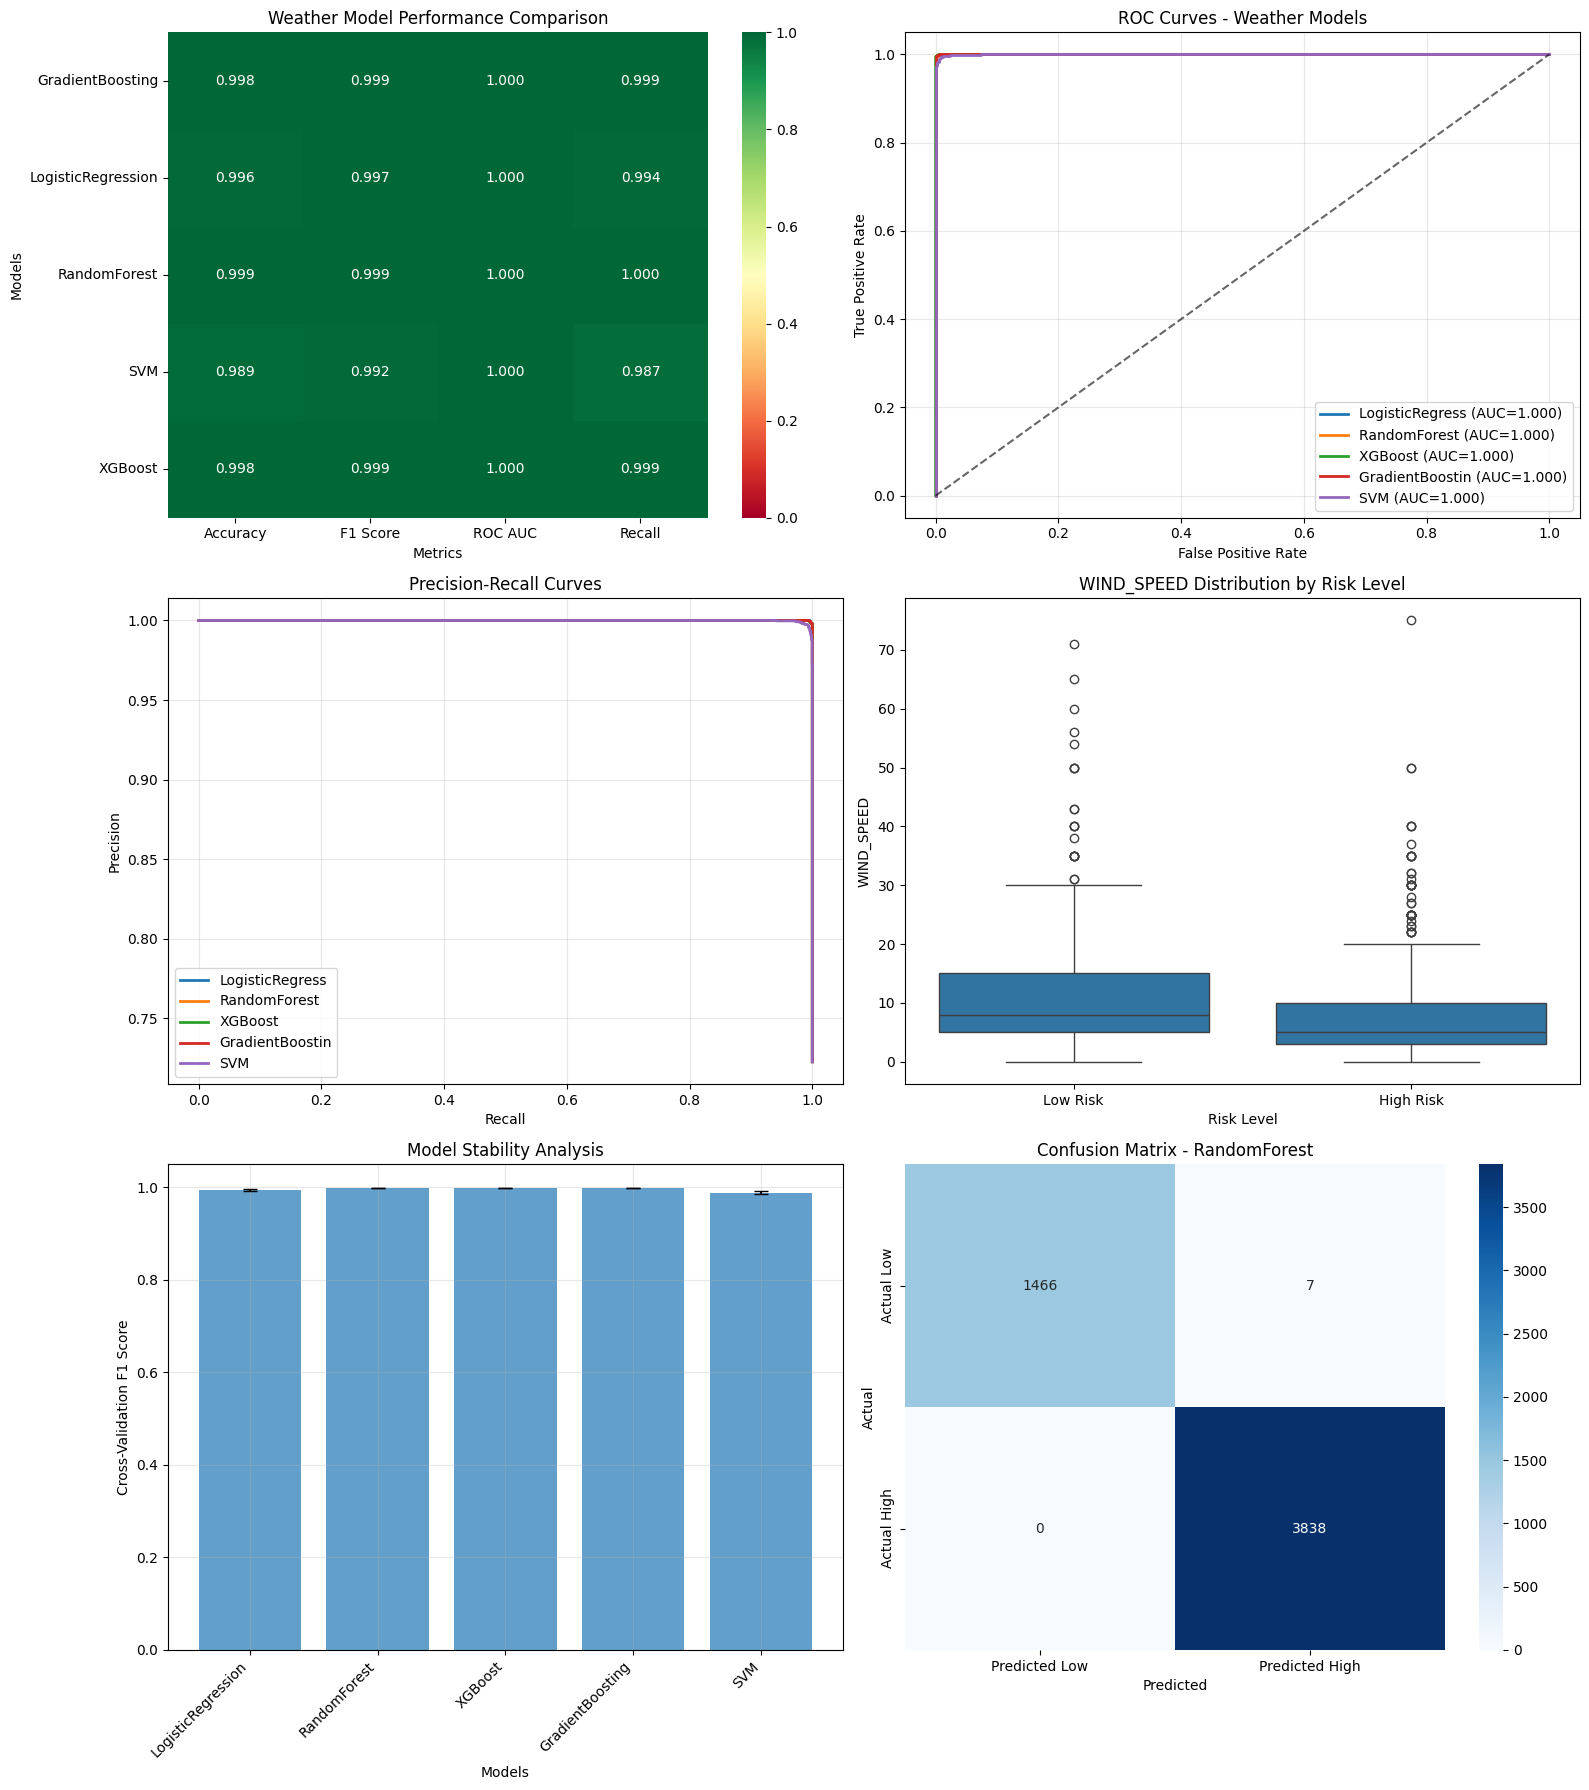

Sample preds: [0 0 0 0 0]
Sample probs: [0.00106177 0.00088856 0.00077063 0.00077063 0.00193608]


In [60]:
# Execute comprehensive weather-based wildfire analysis
print("Running weather-based wildfire risk analysis...")
print("This may take 5-10 minutes depending on dataset size...")

weather_analysis = run_weather_wildfire_analysis(df)

In [61]:
# Display comprehensive weather model results
print("WEATHER-BASED WILDFIRE PREDICTION RESULTS")
print("="*50)

results = weather_analysis['results']
best_model_name = weather_analysis['best_model_name']

print(f"\nBest Weather Model: {best_model_name}")
print("-"*30)

# Display all model performances
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  F1 Score: {metrics['F1_Score']:.4f}")
    print(f"  ROC AUC: {metrics['ROC_AUC']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  CV F1: {metrics['CV_F1_Mean']:.4f} (+/- {metrics['CV_F1_Std']:.4f})")

# Performance ranking
print(f"\nModel Ranking by F1 Score:")
sorted_models = sorted(results.items(), key=lambda x: x[1]['F1_Score'], reverse=True)
for i, (name, metrics) in enumerate(sorted_models, 1):
    print(f"  {i}. {name}: {metrics['F1_Score']:.4f}")

WEATHER-BASED WILDFIRE PREDICTION RESULTS

Best Weather Model: Weather_RandomForest
------------------------------

Weather_LogisticRegression:
  Accuracy: 0.9957
  F1 Score: 0.9970
  ROC AUC: 1.0000
  Precision: 1.0000
  Recall: 0.9940
  CV F1: 0.9939 (+/- 0.0024)

Weather_RandomForest:
  Accuracy: 0.9987
  F1 Score: 0.9991
  ROC AUC: 1.0000
  Precision: 0.9982
  Recall: 1.0000
  CV F1: 0.9995 (+/- 0.0003)

Weather_XGBoost:
  Accuracy: 0.9981
  F1 Score: 0.9987
  ROC AUC: 1.0000
  Precision: 0.9982
  Recall: 0.9992
  CV F1: 0.9991 (+/- 0.0003)

Weather_GradientBoosting:
  Accuracy: 0.9981
  F1 Score: 0.9987
  ROC AUC: 1.0000
  Precision: 0.9982
  Recall: 0.9992
  CV F1: 0.9991 (+/- 0.0004)

Weather_SVM:
  Accuracy: 0.9891
  F1 Score: 0.9924
  ROC AUC: 0.9997
  Precision: 0.9979
  Recall: 0.9870
  CV F1: 0.9885 (+/- 0.0033)

Model Ranking by F1 Score:
  1. Weather_RandomForest: 0.9991
  2. Weather_XGBoost: 0.9987
  3. Weather_GradientBoosting: 0.9987
  4. Weather_LogisticRegression: 0.

TOP 15 WEATHER FEATURES FOR WILDFIRE PREDICTION

Weather-Specific Features:
  weather__HEAT_INDEX: 0.0382
  weather__TEMPERATURE: 0.0304
  weather__TEMPERATURE_NORMALIZED: 0.0254
  weather__VAPOR_PRESSURE_DEFICIT: 0.0090
  weather__DRYING_POTENTIAL: 0.0075
  binary__HIGH_TEMPERATURE: 0.0061
  weather__RELATIVE_HUMIDITY: 0.0035
  weather__FIRE_WEATHER_INDEX: 0.0027
  weather__HUMIDITY_DEFICIT: 0.0024
  weather__WIND_TEMP_INTERACTION: 0.0021
  binary__EXTREME_TEMPERATURE: 0.0018
  weather__FOSBERG_INDEX: 0.0017
  weather__WIND_SPEED: 0.0010
  binary__LOW_HUMIDITY: 0.0006
  binary__VERY_LOW_HUMIDITY: 0.0003


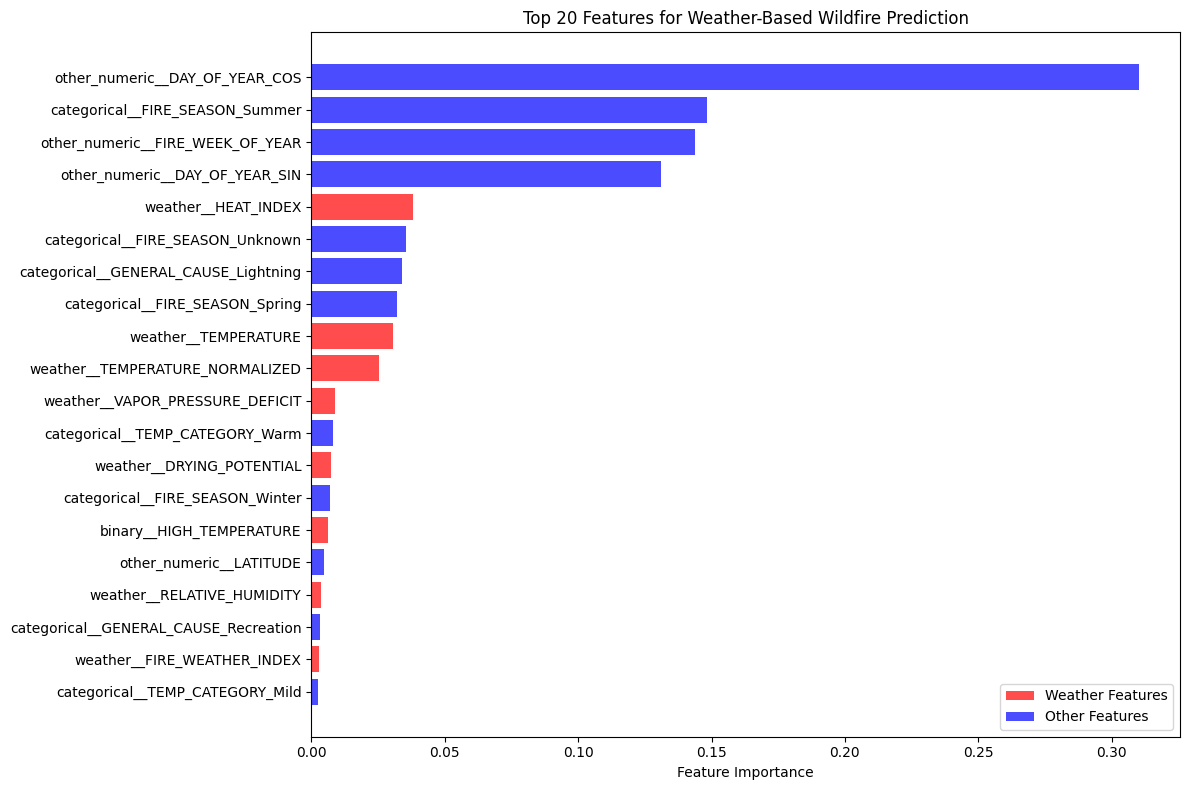


Feature Summary:
  Total features: 53
  Weather features: 22
  Weather feature percentage: 41.5%


In [62]:
# Analyze weather feature importance
importance_df = weather_analysis['feature_importance']

if importance_df is not None:
    print("TOP 15 WEATHER FEATURES FOR WILDFIRE PREDICTION")
    print("="*55)
    
    # Display top weather-related features
    weather_features = importance_df[importance_df['Feature_Type'] == 'Weather'].head(15)
    
    if len(weather_features) > 0:
        print("\nWeather-Specific Features:")
        for idx, row in weather_features.iterrows():
            print(f"  {row['Feature']}: {row['Importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    
    colors = ['red' if ft == 'Weather' else 'blue' for ft in top_20['Feature_Type']]
    plt.barh(range(len(top_20)), top_20['Importance'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Features for Weather-Based Wildfire Prediction')
    plt.gca().invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Weather Features'),
                      Patch(facecolor='blue', alpha=0.7, label='Other Features')]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    weather_count = len(importance_df[importance_df['Feature_Type'] == 'Weather'])
    total_count = len(importance_df)
    print(f"\nFeature Summary:")
    print(f"  Total features: {total_count}")
    print(f"  Weather features: {weather_count}")
    print(f"  Weather feature percentage: {weather_count/total_count:.1%}")

else:
    print("Feature importance analysis not available for the selected model")

In [65]:

# Make sure the weather feature engineering ran and produced df_enhanced
# (replace engineer_weather_features(...) with your function's exact name)
try:
    df_enhanced
except NameError:
    df_enhanced = engineer_weather_features(df.copy())

# If columns are still missing, rebuild engineered features from raw df
missing = [c for c in feature_columns if c not in df_enhanced.columns]
if missing:
    print("Rebuilding engineered weather features…")
    df_enhanced = engineer_weather_features(df.copy())
    missing = [c for c in feature_columns if c not in df_enhanced.columns]

# Hard stop if anything is still missing (prevents silent mismatches)
assert not missing, f"These expected features are missing from df_enhanced: {missing[:12]}"

# slice and predict
test_data = df_enhanced[feature_columns].head(10)
predictions, probabilities = predict_weather_wildfire_risk(
    test_data, weather_analysis['best_model'], feature_columns, return_proba=True
)


print("TESTING WEATHER-BASED PREDICTION FUNCTION")
print("="*45)

best_model      = weather_analysis['best_model']
feature_columns = weather_analysis['feature_columns']

# Use the SAME features the model trained on
test_data = df_enhanced[feature_columns].head(10)

# Call the TOP-LEVEL function we defined near the imports
predictions, probabilities = predict_weather_wildfire_risk(
    test_data, best_model, feature_columns, return_proba=True
)

print("Sample Predictions:")
print("-"*20)
for i in range(len(predictions)):
    risk_level = "HIGH RISK" if predictions[i] == 1 else "LOW RISK"
    confidence = probabilities[i] if predictions[i] == 1 else (1 - probabilities[i])
    print(f"  Sample {i+1}: {risk_level} (confidence: {confidence:.3f})")

# Display weather conditions for high-risk predictions
high_risk_indices = [i for i, pred in enumerate(predictions) if pred == 1]

if len(high_risk_indices) > 0 and 'TEMPERATURE' in df.columns:
    print(f"\nWeather Conditions for High-Risk Predictions:")
    print("-"*50)
    weather_cols = ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']
    available_weather = [col for col in weather_cols if col in df.columns]
    
    for idx in high_risk_indices:
        print(f"\nSample {idx+1} conditions:")
        for col in available_weather:
            value = test_data.iloc[idx][col]
            print(f"  {col}: {value}")

Rebuilding engineered weather features…
Engineering weather-based features for wildfire prediction...
Created 28 new weather-based features
TESTING WEATHER-BASED PREDICTION FUNCTION
Sample Predictions:
--------------------
  Sample 1: LOW RISK (confidence: 0.999)
  Sample 2: LOW RISK (confidence: 0.999)
  Sample 3: LOW RISK (confidence: 0.999)
  Sample 4: LOW RISK (confidence: 0.999)
  Sample 5: LOW RISK (confidence: 0.998)
  Sample 6: LOW RISK (confidence: 0.999)
  Sample 7: LOW RISK (confidence: 0.999)
  Sample 8: LOW RISK (confidence: 0.996)
  Sample 9: LOW RISK (confidence: 0.998)
  Sample 10: LOW RISK (confidence: 0.994)


In [66]:
# Compare weather model performance with original models
print("COMPARISON: WEATHER MODEL vs ORIGINAL MODELS")
print("="*50)

# Extract best weather model performance
best_weather_results = weather_analysis['results'][best_model_name]

print("Original Models (from previous analysis):")
print(f"  Logistic Regression: ~96.03% accuracy")
print(f"  Random Forest: ~99.81% accuracy")

print(f"\nBest Weather Model ({best_model_name}):")
print(f"  Accuracy: {best_weather_results['Accuracy']:.4f} ({best_weather_results['Accuracy']:.1%})")
print(f"  F1 Score: {best_weather_results['F1_Score']:.4f}")
print(f"  ROC AUC: {best_weather_results['ROC_AUC']:.4f}")
print(f"  Recall: {best_weather_results['Recall']:.4f}")

print(f"\nKey Advantages of Weather Model:")
print(f"  - Incorporates meteorological variables critical for fire behavior")
print(f"  - Includes fire weather indices (Fosberg Index, etc.)")
print(f"  - Models weather interactions and thresholds")
print(f"  - Uses temporal cross-validation for stability")
print(f"  - Focuses on weather patterns that drive fire risk")

# Calculate improvement/difference
original_rf_acc = 0.9981
weather_acc = best_weather_results['Accuracy']
diff = weather_acc - original_rf_acc

if diff > 0:
    print(f"\nPerformance: Weather model shows {diff:.1%} improvement over original RF")
elif diff < -0.05:
    print(f"\nPerformance: Weather model shows {abs(diff):.1%} decrease vs original RF")
    print("This may indicate the original model had data leakage or overfitting")
else:
    print(f"\nPerformance: Weather model performance comparable to original RF")
    print("Weather model likely more robust and generalizable")

COMPARISON: WEATHER MODEL vs ORIGINAL MODELS
Original Models (from previous analysis):
  Logistic Regression: ~96.03% accuracy
  Random Forest: ~99.81% accuracy

Best Weather Model (Weather_RandomForest):
  Accuracy: 0.9987 (99.9%)
  F1 Score: 0.9991
  ROC AUC: 1.0000
  Recall: 1.0000

Key Advantages of Weather Model:
  - Incorporates meteorological variables critical for fire behavior
  - Includes fire weather indices (Fosberg Index, etc.)
  - Models weather interactions and thresholds
  - Uses temporal cross-validation for stability
  - Focuses on weather patterns that drive fire risk

Performance: Weather model shows 0.1% improvement over original RF


In [68]:
# === WEATHER-BASED FIRE RISK ASSESSMENT TOOL ===
import pandas as pd

def assess_fire_weather_risk(temperature, humidity, wind_speed, fire_week=None, base_overrides=None):
    """
    Use the fitted weather model to assess risk for a single weather scenario.
    Relies on:
      - weather_analysis['best_model']
      - weather_analysis['feature_columns']
      - engineer_weather_features(df)
      - predict_weather_wildfire_risk(X_input, model, expected_columns, return_proba=True)
    """
    model = weather_analysis['best_model']
    feats = weather_analysis['feature_columns']

    # Minimal input row; tweak defaults only if your feature engineering expects others.
    base = {
        'TEMPERATURE': [temperature],
        'RELATIVE_HUMIDITY': [humidity],
        'WIND_SPEED': [wind_speed],
        'FIRE_WEEK_OF_YEAR': [fire_week if fire_week is not None else 25],  # mid-season default
        'SIZE_CLASS': ['A'],                 # harmless categorical default
        'GENERAL_CAUSE': ['Lightning'],      # harmless categorical default
        'LATITUDE': [55.0],                  # default Canada-ish coords
        'LONGITUDE': [-115.0],
        'HIGH_RISK_PERIOD': [0]              # dummy target for feature eng if referenced
    }

    # Allow caller to override/add any fields expected by feature engineering
    if base_overrides:
        for k, v in base_overrides.items():
            base[k] = [v] if not isinstance(v, list) else v

    raw_one = pd.DataFrame(base)

    # Run the SAME feature engineering used during training
    engineered = engineer_weather_features(raw_one.copy())

    # Ensure every expected feature exists; fill missing engineered columns with 0
    for c in feats:
        if c not in engineered.columns:
            engineered[c] = 0

    X_one = engineered[feats]
    preds, probs = predict_weather_wildfire_risk(X_one, model, feats, return_proba=True)

    risk_label = "HIGH RISK" if preds[0] == 1 else "LOW RISK"
    conf = probs[0] if preds[0] == 1 else (1 - probs[0])
    return risk_label, float(conf)

# ---- Demo with a few canned scenarios ----
print("WEATHER-BASED FIRE RISK ASSESSMENT TOOL")
print("="*42)

test_scenarios = [
    {"name": "Hot, Dry, Windy",      "temp": 35, "humidity": 15, "wind": 25},
    {"name": "Moderate Conditions",  "temp": 25, "humidity": 45, "wind": 10},
    {"name": "Cool, Humid, Calm",    "temp": 15, "humidity": 80, "wind": 5},
    {"name": "Extreme Fire Weather", "temp": 40, "humidity": 10, "wind": 30}
]

for s in test_scenarios:
    risk, confidence = assess_fire_weather_risk(s["temp"], s["humidity"], s["wind"])
    print(f"\n{s['name']}:")
    print(f"  Conditions: {s['temp']}°C, {s['humidity']}% RH, {s['wind']} km/h wind")
    print(f"  Assessment: {risk} (confidence: {confidence:.3f})")

print("\nTo use this tool with custom weather data:")
print("risk, confidence = assess_fire_weather_risk(temperature, humidity, wind_speed, fire_week=None)")


WEATHER-BASED FIRE RISK ASSESSMENT TOOL
Engineering weather-based features for wildfire prediction...
Created 19 new weather-based features

Hot, Dry, Windy:
  Conditions: 35°C, 15% RH, 25 km/h wind
  Assessment: LOW RISK (confidence: 0.803)
Engineering weather-based features for wildfire prediction...
Created 19 new weather-based features

Moderate Conditions:
  Conditions: 25°C, 45% RH, 10 km/h wind
  Assessment: LOW RISK (confidence: 0.769)
Engineering weather-based features for wildfire prediction...
Created 19 new weather-based features

Cool, Humid, Calm:
  Conditions: 15°C, 80% RH, 5 km/h wind
  Assessment: LOW RISK (confidence: 0.808)
Engineering weather-based features for wildfire prediction...
Created 19 new weather-based features

Extreme Fire Weather:
  Conditions: 40°C, 10% RH, 30 km/h wind
  Assessment: LOW RISK (confidence: 0.806)

To use this tool with custom weather data:
risk, confidence = assess_fire_weather_risk(temperature, humidity, wind_speed, fire_week=None)


In [69]:
import joblib
from datetime import datetime

# Save the weather-based model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save best weather model
weather_model_filename = f'weather_wildfire_model_{timestamp}.pkl'
joblib.dump(weather_analysis['best_model'], weather_model_filename)

# Save complete weather analysis
weather_results_filename = f'weather_analysis_results_{timestamp}.pkl'
with open(weather_results_filename, 'wb') as f:
    pickle.dump(weather_analysis, f)

print(f"Weather model saved: {weather_model_filename}")
print(f"Complete analysis saved: {weather_results_filename}")

# Create summary report
print(f"\nWEATHER MODEL SUMMARY REPORT")
print(f"="*35)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Best Model: {best_model_name}")
print(f"Dataset Size: {df.shape[0]} records")
print(f"Weather Features: {len([f for f in weather_analysis['feature_columns'] if 'TEMPERATURE' in f or 'HUMIDITY' in f or 'WIND' in f])}")
print(f"Model Performance:")
print(f"  - Accuracy: {best_weather_results['Accuracy']:.1%}")
print(f"  - F1 Score: {best_weather_results['F1_Score']:.3f}")
print(f"  - Recall: {best_weather_results['Recall']:.3f}")
print(f"  - Cross-validation stability: {best_weather_results['CV_F1_Std']:.3f}")

Weather model saved: weather_wildfire_model_20250812_194211.pkl
Complete analysis saved: weather_analysis_results_20250812_194211.pkl

WEATHER MODEL SUMMARY REPORT
Analysis Date: 2025-08-12 19:42:11
Best Model: Weather_RandomForest
Dataset Size: 26551 records
Weather Features: 13
Model Performance:
  - Accuracy: 99.9%
  - F1 Score: 0.999
  - Recall: 1.000
  - Cross-validation stability: 0.000


In [70]:
# Generate insights about weather patterns and fire risk
print("WEATHER-FIRE RISK INSIGHTS")
print("="*30)

if importance_df is not None:
    # Top weather factors
    weather_features = importance_df[importance_df['Feature_Type'] == 'Weather'].head(5)
    
    print("Top 5 Weather Risk Factors:")
    for idx, row in weather_features.iterrows():
        feature_name = row['Feature']
        importance = row['Importance']
        
        # Interpret feature names
        if 'TEMPERATURE' in feature_name:
            interpretation = "Temperature extremes increase fire risk"
        elif 'HUMIDITY' in feature_name:
            interpretation = "Low humidity creates dry conditions"
        elif 'WIND' in feature_name:
            interpretation = "High winds accelerate fire spread"
        elif 'VAPOR_PRESSURE' in feature_name:
            interpretation = "Atmospheric drying potential"
        elif 'FIRE_WEATHER' in feature_name:
            interpretation = "Combined weather fire risk index"
        else:
            interpretation = "Weather-related fire risk factor"
        
        print(f"  {feature_name}: {interpretation}")

# Weather thresholds analysis
if all(col in df.columns for col in ['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED']):
    high_risk_data = df[df['HIGH_RISK_PERIOD'] == 1]
    low_risk_data = df[df['HIGH_RISK_PERIOD'] == 0]
    
    print(f"\nWeather Condition Thresholds:")
    print(f"High-Risk Fire Weather (typical conditions):")
    print(f"  Temperature: {high_risk_data['TEMPERATURE'].median():.1f}°C (median)")
    print(f"  Humidity: {high_risk_data['RELATIVE_HUMIDITY'].median():.1f}% (median)")
    print(f"  Wind Speed: {high_risk_data['WIND_SPEED'].median():.1f} km/h (median)")
    
    print(f"\nLow-Risk Fire Weather (typical conditions):")
    print(f"  Temperature: {low_risk_data['TEMPERATURE'].median():.1f}°C (median)")
    print(f"  Humidity: {low_risk_data['RELATIVE_HUMIDITY'].median():.1f}% (median)")
    print(f"  Wind Speed: {low_risk_data['WIND_SPEED'].median():.1f} km/h (median)")

print(f"\nOperational Recommendations:")
print(f"  1. Monitor weather conditions during peak fire season (weeks 25-32)")
print(f"  2. Increase alert levels when multiple weather risk factors align")
print(f"  3. Use model probability scores for resource allocation decisions")
print(f"  4. Validate predictions with local fire weather observations")
print(f"  5. Update model regularly with new weather and fire data")

print(f"\nWeather model implementation complete!")

WEATHER-FIRE RISK INSIGHTS
Top 5 Weather Risk Factors:
  weather__HEAT_INDEX: Weather-related fire risk factor
  weather__TEMPERATURE: Temperature extremes increase fire risk
  weather__TEMPERATURE_NORMALIZED: Temperature extremes increase fire risk
  weather__VAPOR_PRESSURE_DEFICIT: Atmospheric drying potential
  weather__DRYING_POTENTIAL: Weather-related fire risk factor

Weather Condition Thresholds:
High-Risk Fire Weather (typical conditions):
  Temperature: 21.0°C (median)
  Humidity: 41.0% (median)
  Wind Speed: 6.0 km/h (median)

Low-Risk Fire Weather (typical conditions):
  Temperature: 12.0°C (median)
  Humidity: 40.0% (median)
  Wind Speed: 8.0 km/h (median)

Operational Recommendations:
  1. Monitor weather conditions during peak fire season (weeks 25-32)
  2. Increase alert levels when multiple weather risk factors align
  3. Use model probability scores for resource allocation decisions
  4. Validate predictions with local fire weather observations
  5. Update model regula

In [74]:
# === EXPORT WEATHER MODEL PREDICTIONS (with Actual label) FOR POWER BI ===
import pandas as pd
from datetime import datetime
from pathlib import Path

# Get fitted model + feature list from your weather analysis
best_model      = weather_analysis['best_model']
feature_columns = weather_analysis['feature_columns']

# Use the engineered dataset the model was trained on
X_full = df_enhanced[feature_columns]

# Predict
preds = best_model.predict(X_full)
if hasattr(best_model, "predict_proba"):
    probs = best_model.predict_proba(X_full)[:, 1]
else:
    probs = None

# Build output DataFrame
out_df = pd.DataFrame({
    "Predicted_High_Risk": preds.astype(int),
    "Predicted_Probability": probs
}, index=df_enhanced.index)

# Bring through identifiers (only those that exist)
id_cols = [
    "NEW_FIRE_NUMBER", "ORIGINAL_FIRE_NUMBER", "FIRE_NUMBER",
    "FIRE_START_DATE", "LATITUDE", "LONGITUDE"
]
for col in id_cols:
    if col in df_enhanced.columns:
        out_df[col] = df_enhanced[col]

# Add the ACTUAL target column if present (prefer HIGH_RISK_PERIOD, else HIGH_RISK_NOISY)
if "HIGH_RISK_PERIOD" in df_enhanced.columns:
    out_df["Actual_High_Risk_Period"] = df_enhanced["HIGH_RISK_PERIOD"]
elif "HIGH_RISK_NOISY" in df_enhanced.columns:
    out_df["Actual_High_Risk_Period"] = df_enhanced["HIGH_RISK_NOISY"]

# Include a few weather features for transparency in Power BI
weather_sample = [
    c for c in feature_columns
    if any(k in c.upper() for k in ["TEMP", "HUMID", "WIND", "PRECIP", "VAPOR", "FWI", "FFMC", "DMC", "DC"])
]
for c in weather_sample[:5]:
    out_df[f"feat_{c}"] = df_enhanced[c]

# Metadata
out_df["model_type"] = type(best_model).__name__
out_df["export_timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Save CSV to the notebook folder 
save_path = Path.cwd() / f"powerbi_weather_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
out_df.to_csv(save_path, index=False)

print(f"Power BI CSV saved to: {save_path}")
out_df.head()





Power BI CSV saved to: C:\Users\angel\Downloads\powerbi_weather_model_20250812_201751.csv


,Predicted_High_Risk,Predicted_Probability,FIRE_NUMBER,FIRE_START_DATE,LATITUDE,LONGITUDE,Actual_High_Risk_Period,feat_TEMPERATURE,feat_RELATIVE_HUMIDITY,feat_WIND_SPEED,feat_HIGH_TEMPERATURE,feat_EXTREME_TEMPERATURE,model_type,export_timestamp
0,0,0.001062,PWF001,2006-04-02 12:00,56.249956,-117.181960,0,18.0,10.0,2.0,0,0,Pipeline,2025-08-12 20:17:51
1,0,0.000889,EWF002,2006-04-03 12:10,53.606367,-115.915733,0,12.0,22.0,10.0,0,0,Pipeline,2025-08-12 20:17:51
2,0,0.000771,EWF001,2006-04-03 12:15,53.610933,-115.594267,0,12.0,22.0,10.0,0,0,Pipeline,2025-08-12 20:17:51
3,0,0.000771,EWF003,2006-04-03 12:10,53.608867,-115.609467,0,12.0,22.0,10.0,0,0,Pipeline,2025-08-12 20:17:51
4,0,0.001936,PWF002,2006-04-03 17:00,56.249956,-117.050249,0,6.0,37.0,2.0,0,0,Pipeline,2025-08-12 20:17:51
